# Importaciones

In [1]:
!pip install mapclassify
!pip install geopandas
!pip install factor_analyzer
!pip install plotnine


In [2]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10


In [3]:
df = pd.read_csv('02_componentes_minmax.csv')


# **Funciones**

In [4]:
# Definir la función generalized_mean
def generalized_mean(components, beta):
    EPSILON = 1e-8  # Pequeño valor constante
    if beta != 0:
        return np.power(np.mean(np.power(components + EPSILON, beta)), 1 / beta)
    else:
        return np.power(np.prod(components + EPSILON), 1 / len(components))

# Definir la función de normalización Min-Max
def min_max_normalize(series):
    return ((series - series.min()) / (series.max() - series.min())) * 100

# Calcular el intervalo de confianza al 95% para cada columna
def calcular_intervalo_confianza(data):
    mean = np.mean(data)
    std_error = np.std(data, ddof=1) / np.sqrt(len(data))
    margin_of_error = 1.96 * std_error  # 1.96 es el valor crítico para un intervalo de confianza del 95%
    return mean, mean - margin_of_error, mean + margin_of_error

In [5]:
# Función para realizar bootstrap: sensibilidad e incertidumbre
def bootstrap_analysis(X, beta, n_bootstrap=1000):
    n_rows = X.shape[0]

    # Función para calcular el índice compuesto de una muestra
    def compute_index(sample):
        return generalized_mean(sample, beta)

    # Lista para almacenar resultados de bootstrap
    bootstrap_results = []

    for _ in range(n_bootstrap):
        # Muestreo con reemplazo
        sample_indices = np.random.choice(X.index, size=n_rows, replace=True)
        sample = X.loc[sample_indices]
        # Asegurarse de que los valores están en el rango [0, 100]
        sample = np.clip(sample, 0, 100)
        # Calcular índice compuesto para la muestra
        index_values = sample.apply(lambda row: compute_index(row.values), axis=1)
        bootstrap_results.extend(index_values)

    # Convertir resultados bootstrap a una Serie
    bootstrap_series = pd.Series(bootstrap_results)

    # Calcular varianza
    variance = bootstrap_series.var()

    # Calcular intervalo de confianza
    mean, lower_bound, upper_bound = calcular_intervalo_confianza(bootstrap_series)

    # Crear DataFrame con los resultados de bootstrap
    bootstrap_df = pd.DataFrame({
        'Bootstrap Index': bootstrap_series
    })

    # Crear DataFrame con las cifras de varianza y intervalo de confianza
    results = pd.DataFrame({
        'Variance': [variance],
        'Confidence Interval Mean': [mean],
        'Confidence Interval Lower': [lower_bound],
        'Confidence Interval Upper': [upper_bound]
    })

    return bootstrap_df, results

In [6]:
# Visualización barras
def plot_bar_chart(df, variables, id_var='country', hue_var='variable', palette="Set2", errorbar='ci'):
    """
    Genera un gráfico de barras con las variables especificadas.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    variables (list): Lista de columnas a utilizar como variables.
    id_var (str): Columna que identifica las categorías (por defecto 'country').
    hue_var (str): Nombre de la variable de agrupación (por defecto 'variable').
    palette (str): Paleta de colores a utilizar (por defecto 'Set2').
    errorbar (str): Tipo de barra de error a mostrar (por defecto 'ci').

    Returns:
    None
    """
    sns.set(style="whitegrid")

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(12, 8))

    # Crear el gráfico de barras
    melted_df = pd.melt(df, id_vars=[id_var], value_vars=variables)
    sns.barplot(x=id_var, y='value', hue=hue_var, data=melted_df, palette=palette, errorbar=errorbar)

    # Añadir título y etiquetas
    plt.xlabel(id_var.capitalize())
    plt.ylabel('Value')
    plt.title('Bar Chart')

    # Rotar las etiquetas del eje x para mejor visualización
    plt.xticks(rotation=90)

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


# Boxplot
def plot_box_chart(df, variables, id_var='country', hue_var='variable', palette="Set2"):
    """
    Genera un gráfico de caja con las variables especificadas.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    variables (list): Lista de columnas a utilizar como variables.
    id_var (str): Columna que identifica las categorías (por defecto 'country').
    hue_var (str): Nombre de la variable de agrupación (por defecto 'variable').
    palette (str): Paleta de colores a utilizar (por defecto 'Set2').

    Returns:
    None
    """
    sns.set(style="whitegrid")

    # Configurar el tamaño del gráfico
    plt.figure(figsize=(12, 8))

    # Crear el gráfico de caja
    melted_df = pd.melt(df, id_vars=[id_var], value_vars=variables)
    sns.boxplot(x=id_var, y='value', hue=hue_var, data=melted_df, palette=palette)

    # Añadir título y etiquetas
    plt.xlabel(id_var.capitalize())
    plt.ylabel('Value')
    plt.title('Box Plot')

    # Rotar las etiquetas del eje x para mejor visualización
    plt.xticks(rotation=90)

    # Ajustar el diseño para evitar solapamiento
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

# Mapas
def plot_maps(df, variables, region_var='region', exclude_regions=None, color='lightgrey', scheme='natural_breaks', k=8, cmap='BrBG'):
    """
    Genera subplots de mapas para las variables especificadas.

    Parameters:
    df (gpd.GeoDataFrame): GeoDataFrame que contiene los datos.
    variables (list): Lista de columnas a utilizar como variables.
    region_var (str): Columna que identifica las regiones (por defecto 'region').
    exclude_regions (list): Lista de regiones a excluir del análisis (por defecto None).
    color (str): Color de fondo de la figura (por defecto 'lightgrey').
    scheme (str): Esquema de clasificación de colores (por defecto 'natural_breaks').
    k (int): Número de intervalos para la clasificación (por defecto 8).
    cmap (str): Paleta de colores a utilizar (por defecto 'BrBG').

    Returns:
    None
    """
    if exclude_regions is not None:
        df = df[~df[region_var].isin(exclude_regions)]

    # Crear la figura y los ejes (subplots)
    fig, axes = plt.subplots(1, len(variables), figsize=(18, 6))  # Ajustar el número de columnas según las variables

    # Si solo hay un gráfico, hacer que 'axes' sea una lista
    if len(variables) == 1:
        axes = [axes]

    # Configurar el color de fondo de la figura
    fig.patch.set_facecolor(color)

    # Iterar sobre cada eje y crear el gráfico correspondiente
    for i, var in enumerate(variables):
        ax = axes[i]
        df.plot(column=var,
                scheme=scheme,
                k=k, cmap=cmap,
                edgecolor='w',
                legend=True,
                ax=ax,
                legend_kwds={'loc': 'upper left', 'fontsize': 8, 'title': var}
                )
        ax.set_title(var)  # Título de cada subplot
        ax.set_axis_off()

    plt.tight_layout()
    
    plt.show()

## **Dimensiones**

* Crear un data frame para almacenar los indices creados al nivel de dimensiones

In [7]:
dimensiones_df = df[['country', 'nuts_code', 'region']]
dimensiones_df.set_index('nuts_code', inplace=True)


* Añadir datos geograficos para representar en mapas

In [8]:
# Cargar los shapefiles de las regiones NUTS
shapefile_path = 'NUTS_RG_20M_2021_3035.shp'
gdf = gpd.read_file(shapefile_path)



In [9]:
dimensiones_gdf=pd.merge(gdf[['NUTS_ID','geometry']], dimensiones_df, how='right', left_on='NUTS_ID', right_on='nuts_code')
dimensiones_gdf = dimensiones_gdf.rename(columns={'NUTS_ID': 'nuts_code'})


In [10]:
overseas = ['Guyane', 'Guadeloupe', 'Martinique', 'La Réunion', 'Mayotte', "Região Autónoma dos Açores", 'Região Autónoma da Madeira', 'Canarias']

* Agrupar los componentes en dimensiones, según la estructura de la Comisión Europea

In [11]:
basic_needs = ["nutrition_medical_care",
               'water_sanitation',
               'safety']

foundations_wellbeing = ['basic_education',
                         'info_comm',
                         'health',
                         'env_quality']

opportunity = ['trust_gov',
               'freedom_choice',
               'inclusive_society',
               'adv_education']

### **Basic needs**

In [12]:
# basic_needs

data = {
    'nuts_code': df['nuts_code']}


for var in basic_needs:
    data[var] = df[var]


X = pd.DataFrame(data)

X.set_index('nuts_code', inplace=True)


In [13]:
# Agregación
beta = 0.5

X['basic_needs'] = X.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Añadir a dimensiones

subset = X['basic_needs']

dimensiones_df = pd.merge(dimensiones_df, subset, on='nuts_code')
dimensiones_gdf = pd.merge(dimensiones_gdf, subset, on='nuts_code')


**[Figura 03.1]**

Figura 03.1


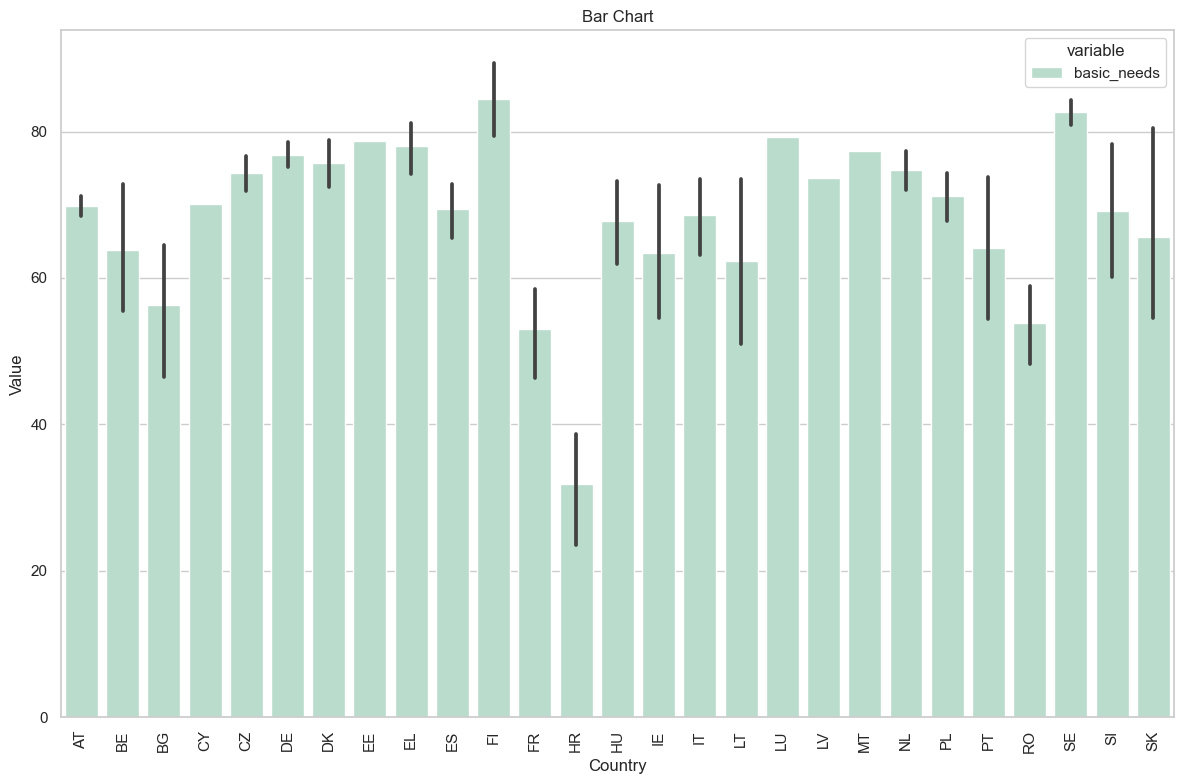

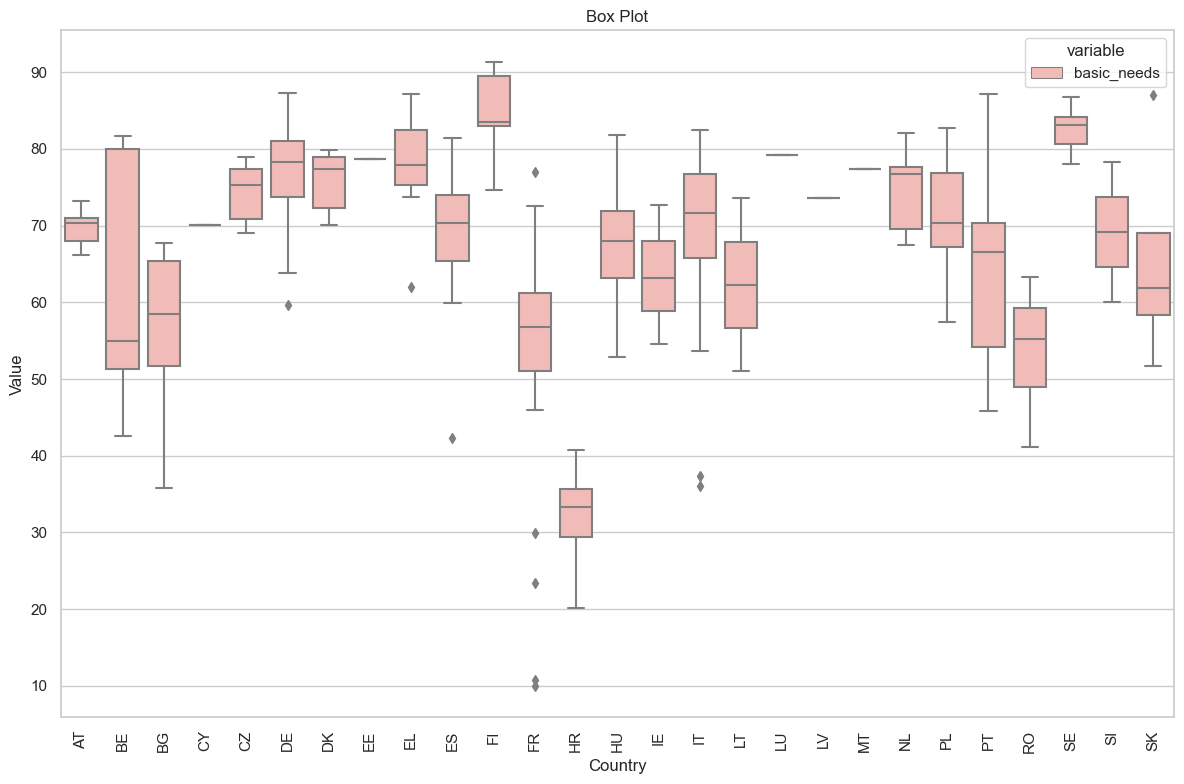

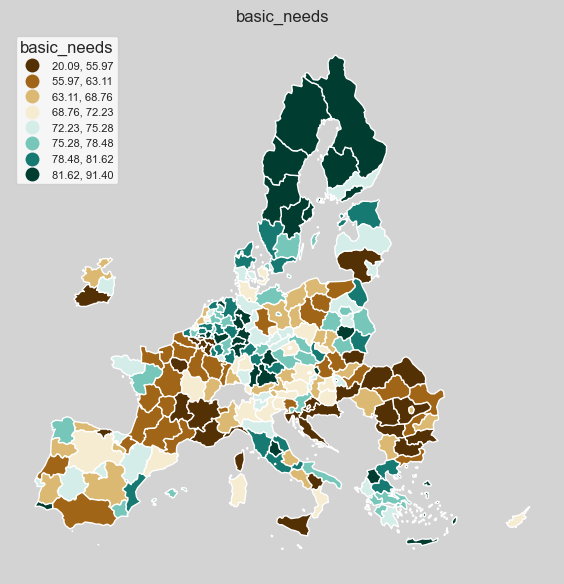

In [14]:
print('Figura 03.1')
variables = ['basic_needs']
plot_bar_chart(dimensiones_df, variables, palette="Pastel2")
plot_box_chart(dimensiones_df, variables, palette="Pastel1")
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='quantiles')





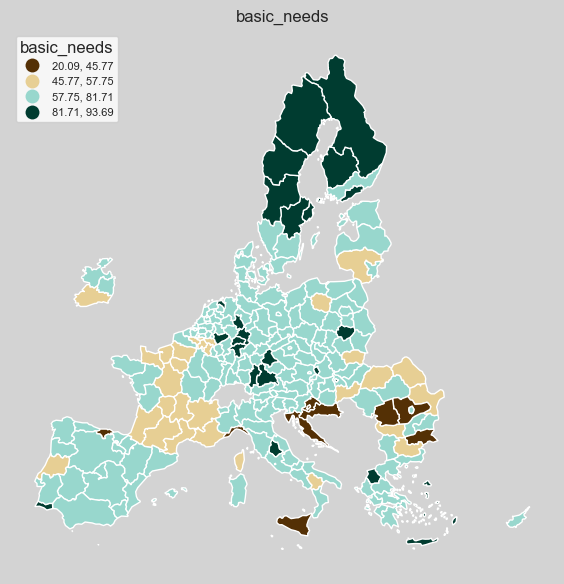

In [15]:
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='stdmean')

* **Analisis de sensibilidad**

**[Figura 03.2]** *Analisis de distintos betas*

Figura 03.2


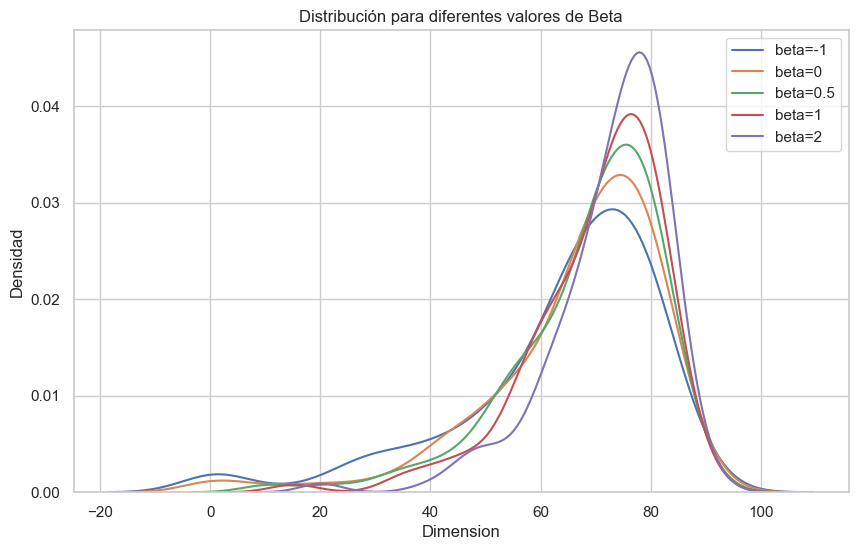

In [16]:
print('Figura 03.2')

data = {
    'nuts_code': df['nuts_code'],
}


for var in basic_needs:
    data[var] = df[var]


X_test = pd.DataFrame(data)

X_test.set_index('nuts_code', inplace=True)

# Valores de beta a probar
beta_values = [-1, 0, 0.5, 1, 2]

# Almacenar los resultados
sensitivity_results = pd.DataFrame(index=X_test.index)

for beta in beta_values:
    sensitivity_results[f'basic_needs{beta}'] = X_test.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Graficar los resultados de sensibilidad para diferentes valores de beta =====================================================

plt.figure(figsize=(10, 6))
for beta in beta_values:
    sns.kdeplot(sensitivity_results[f'basic_needs{beta}'], label=f'beta={beta}', fill=False)

plt.title('Distribución para diferentes valores de Beta')
plt.xlabel('Dimension')
plt.ylabel('Densidad')
plt.legend()

plt.show()

**[Figura 03.3]**

Figura 03.3

Bootstrap:
+---+--------------------+--------------------------+---------------------------+---------------------------+
|   |      Variance      | Confidence Interval Mean | Confidence Interval Lower | Confidence Interval Upper |
+---+--------------------+--------------------------+---------------------------+---------------------------+
| 0 | 186.97514752244936 |    68.61660624112038     |     68.5621258357141      |     68.67108664652666     |
+---+--------------------+--------------------------+---------------------------+---------------------------+

Datos originales:
Varianzas:
188.26885568043105

Intervalo de Confianza al 95%:
(68.59297293678928, 66.86420129531805, 70.3217445782605)



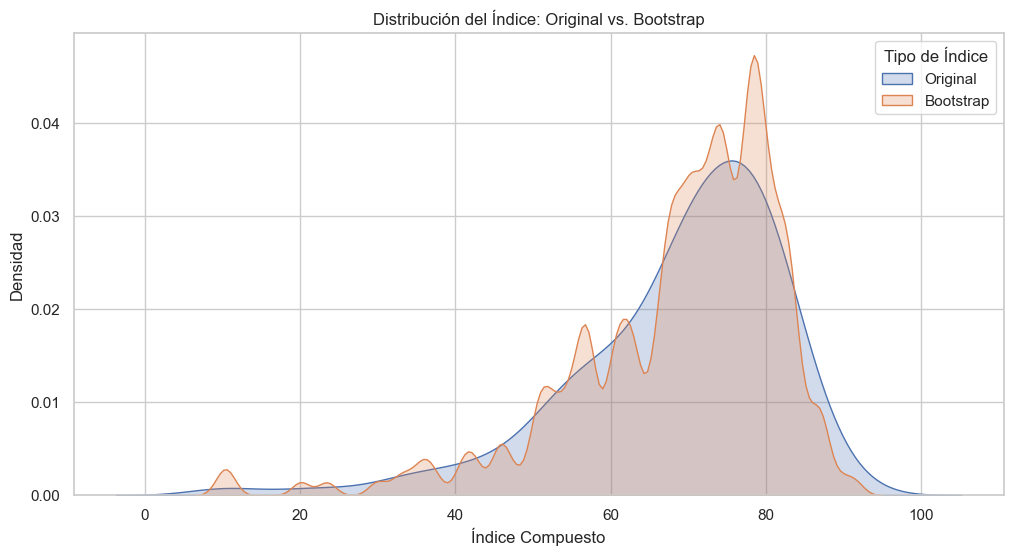

In [17]:
print('Figura 03.3')
print()
n_bootstrap=1000
beta = 0.5

# Realizar análisis bootstrap
bootstrap_df, results = bootstrap_analysis(X, beta, n_bootstrap=n_bootstrap)

print("Bootstrap:")
print(tabulate(results, headers='keys', tablefmt='pretty'))

print()

print('Datos originales:')
# Datos originales

varianza = subset.var()

intervalo_confianza = calcular_intervalo_confianza(subset)

print("Varianzas:")
print(varianza)
print("\nIntervalo de Confianza al 95%:")
print(intervalo_confianza)

print()

# Distribución

X['Indice']='Original'
bootstrap_df['Indice']='Bootstrap'

X_combined = X[['basic_needs', 'Indice']].copy()
bootstrap_combined = bootstrap_df[['Bootstrap Index', 'Indice']].copy()

# Combinar ambos DataFrames
combined_df = pd.concat([X_combined, bootstrap_combined], axis=0)

# Crear la gráfica
plt.figure(figsize=(12, 6))

# Gráfico de densidad para los índices originales y bootstrap
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Original'], x='basic_needs', label='Original', fill=True, common_norm=False)
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Bootstrap'], x='Bootstrap Index', label='Bootstrap', fill=True, common_norm=False)

# Configurar título y etiquetas
plt.title('Distribución del Índice: Original vs. Bootstrap')
plt.xlabel('Índice Compuesto')
plt.ylabel('Densidad')

# Mostrar leyenda
plt.legend(title='Tipo de Índice')

# Mostrar la gráfica
plt.show()

### **Foundations of wellbeing**

In [18]:
# foundations_wellbeing

data = {'nuts_code': df['nuts_code']}


for var in foundations_wellbeing:
    data[var] = df[var]


X = pd.DataFrame(data)

X.set_index('nuts_code', inplace=True)


**[Figura 03.4]**

Figura 03.4


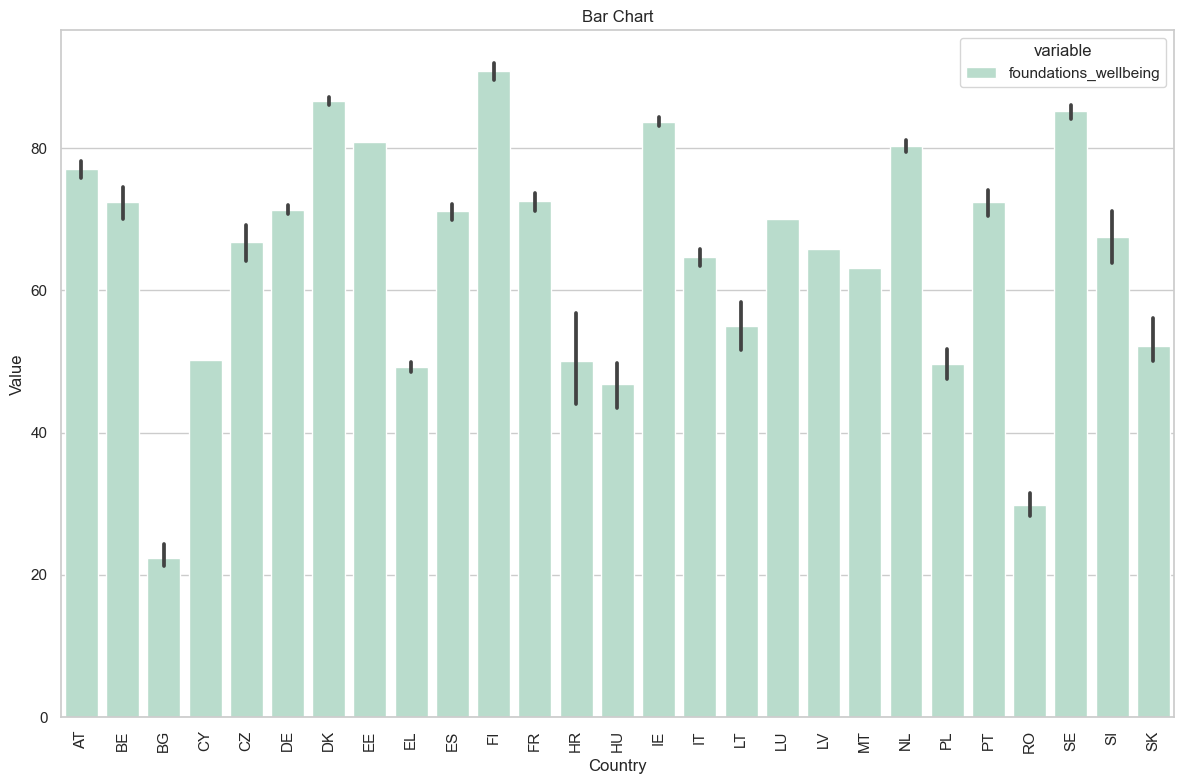

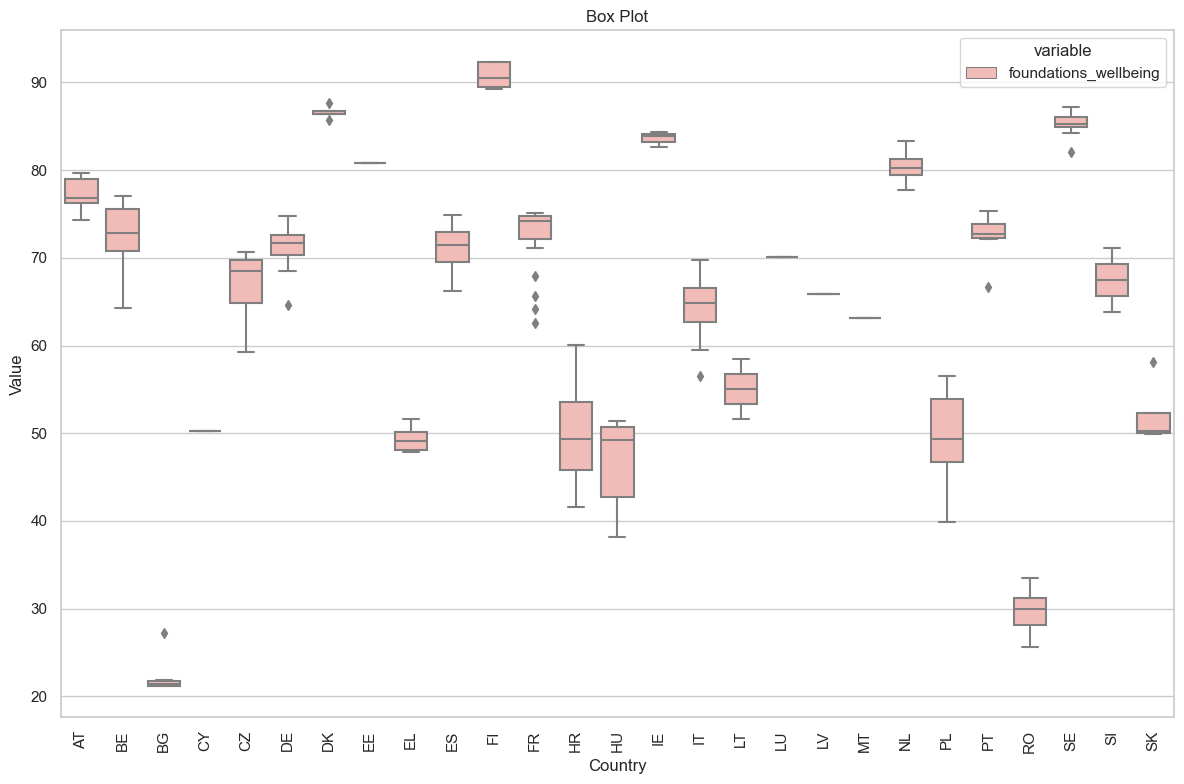

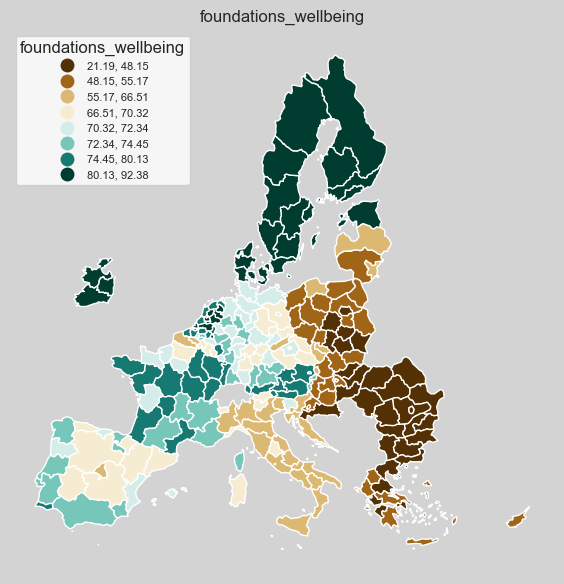

In [19]:
print('Figura 03.4')

# Agregación
beta = 0.5

X['foundations_wellbeing'] = X.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Añadir a dimensiones

subset = X['foundations_wellbeing']

dimensiones_df = pd.merge(dimensiones_df, subset, on='nuts_code')
dimensiones_gdf = pd.merge(dimensiones_gdf, subset, on='nuts_code')

# Graficos y mapas
variables = ['foundations_wellbeing']
plot_bar_chart(dimensiones_df, variables, palette="Pastel2")
plot_box_chart(dimensiones_df, variables, palette="Pastel1")
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='quantiles')


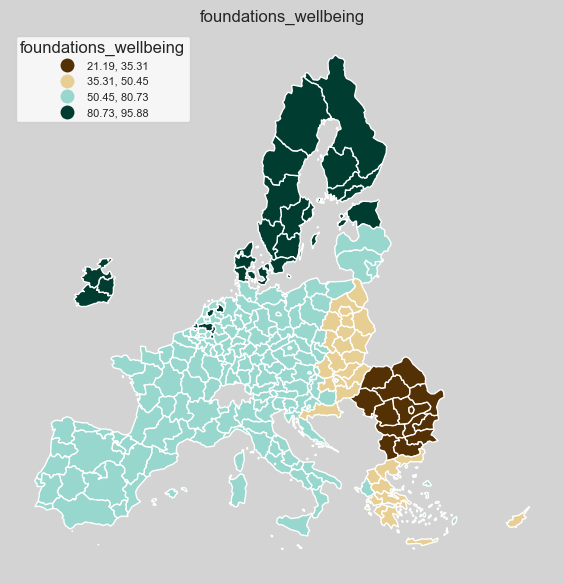

In [20]:
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='stdmean')

* **Analisis de sensibilidad**

**[Figura 03.5]** *Analisis de distintos betas*

Figura 03.5


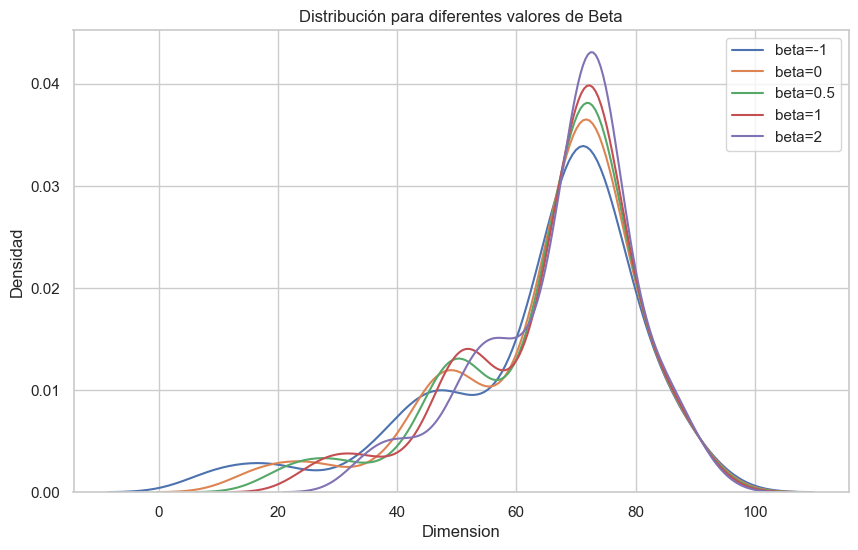

In [21]:
print('Figura 03.5')

data = {
    'nuts_code': df['nuts_code'],
}


for var in foundations_wellbeing:
    data[var] = df[var]


X_test = pd.DataFrame(data)

X_test.set_index('nuts_code', inplace=True)

# Valores de beta a probar
beta_values = [-1, 0, 0.5, 1, 2]

# Almacenar los resultados
sensitivity_results = pd.DataFrame(index=X_test.index)

for beta in beta_values:
    sensitivity_results[f'foundations_wellbeing{beta}'] = X_test.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Graficar los resultados de sensibilidad para diferentes valores de beta =====================================================

plt.figure(figsize=(10, 6))
for beta in beta_values:
    sns.kdeplot(sensitivity_results[f'foundations_wellbeing{beta}'], label=f'beta={beta}', fill=False)

plt.title('Distribución para diferentes valores de Beta')
plt.xlabel('Dimension')
plt.ylabel('Densidad')
plt.legend()
    
plt.show()

**[Figura 03.6]**

Figura 03.6

Bootstrap:
+---+--------------------+--------------------------+---------------------------+---------------------------+
|   |      Variance      | Confidence Interval Mean | Confidence Interval Lower | Confidence Interval Upper |
+---+--------------------+--------------------------+---------------------------+---------------------------+
| 0 | 221.84598067355265 |    65.77754866160063     |     65.71820502305906     |     65.83689230014221     |
+---+--------------------+--------------------------+---------------------------+---------------------------+

Datos originales:
Varianzas:
222.89733081642086

Intervalo de Confianza al 95%:
(65.7500851183707, 63.869033027861754, 67.63113720887966)



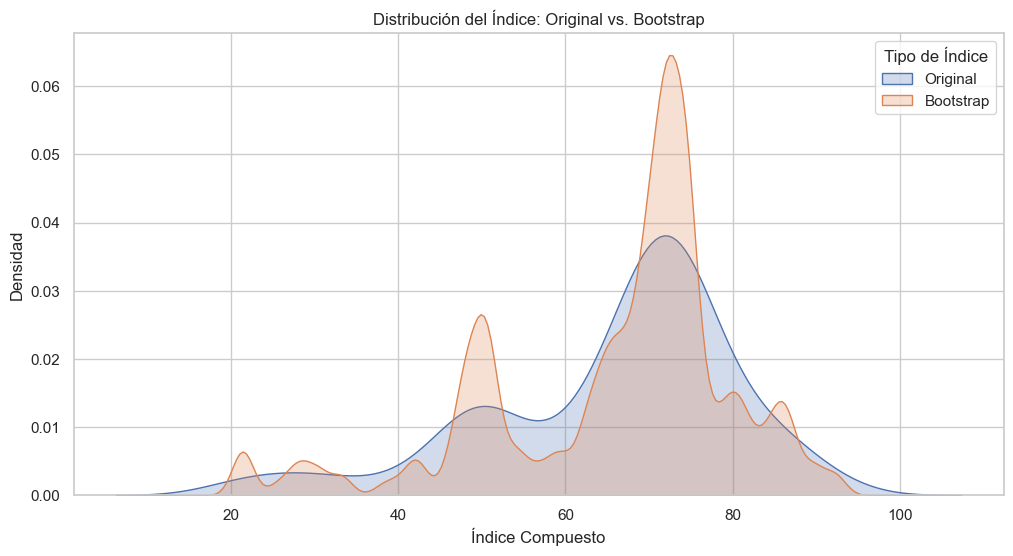

In [22]:
print('Figura 03.6')
print()

n_bootstrap=1000
beta = 0.5

# Realizar análisis bootstrap
bootstrap_df, results = bootstrap_analysis(X, beta, n_bootstrap=n_bootstrap)

print("Bootstrap:")
print(tabulate(results, headers='keys', tablefmt='pretty'))

print()

print('Datos originales:')
# Datos originales

varianza = subset.var()

intervalo_confianza = calcular_intervalo_confianza(subset)

print("Varianzas:")
print(varianza)
print("\nIntervalo de Confianza al 95%:")
print(intervalo_confianza)

print()

# Distribución

X['Indice']='Original'
bootstrap_df['Indice']='Bootstrap'

X_combined = X[['foundations_wellbeing', 'Indice']].copy()
bootstrap_combined = bootstrap_df[['Bootstrap Index', 'Indice']].copy()

# Combinar ambos DataFrames
combined_df = pd.concat([X_combined, bootstrap_combined], axis=0)

# Crear la gráfica
plt.figure(figsize=(12, 6))

# Gráfico de densidad para los índices originales y bootstrap
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Original'], x='foundations_wellbeing', label='Original', fill=True, common_norm=False)
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Bootstrap'], x='Bootstrap Index', label='Bootstrap', fill=True, common_norm=False)

# Configurar título y etiquetas
plt.title('Distribución del Índice: Original vs. Bootstrap')
plt.xlabel('Índice Compuesto')
plt.ylabel('Densidad')

# Mostrar leyenda
plt.legend(title='Tipo de Índice')

# Mostrar la gráfica
plt.show()

### **Opportunity**

In [23]:
# opportunity

data = {'nuts_code': df['nuts_code']}


for var in opportunity:
    data[var] = df[var]


X = pd.DataFrame(data)

X.set_index('nuts_code', inplace=True)


**[Figura 03.7]**

Figura 03.7


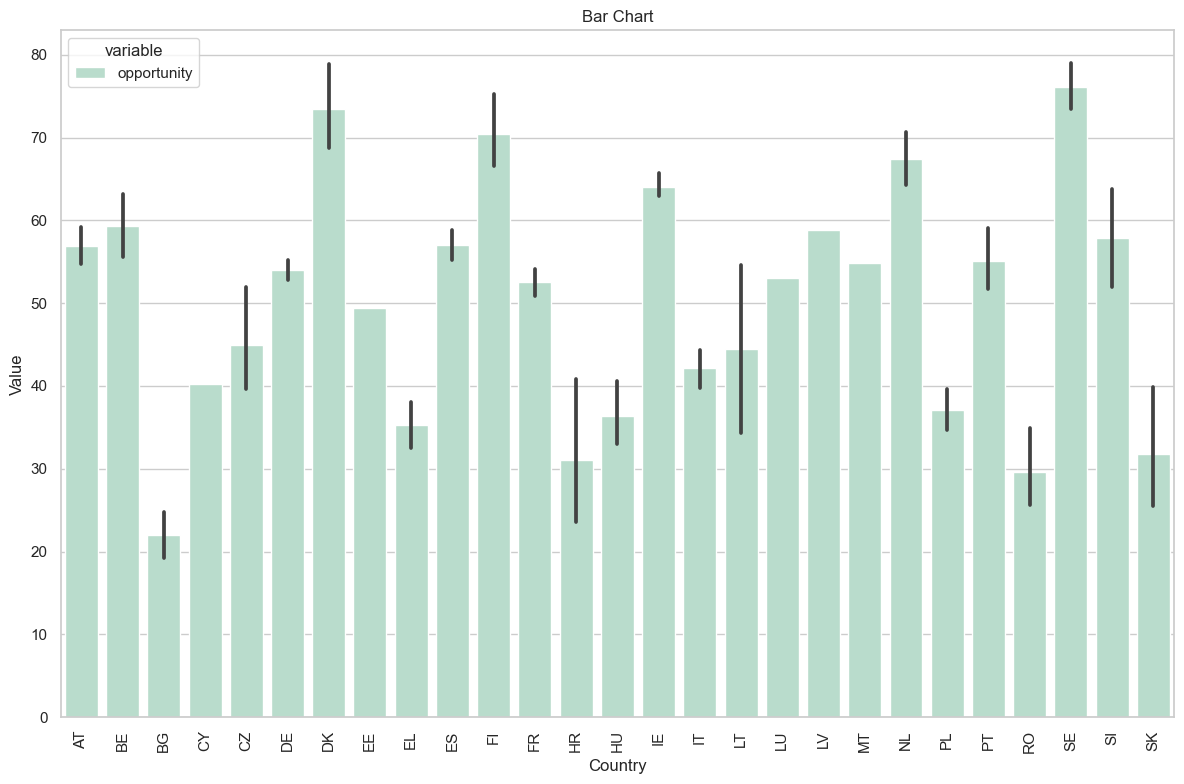

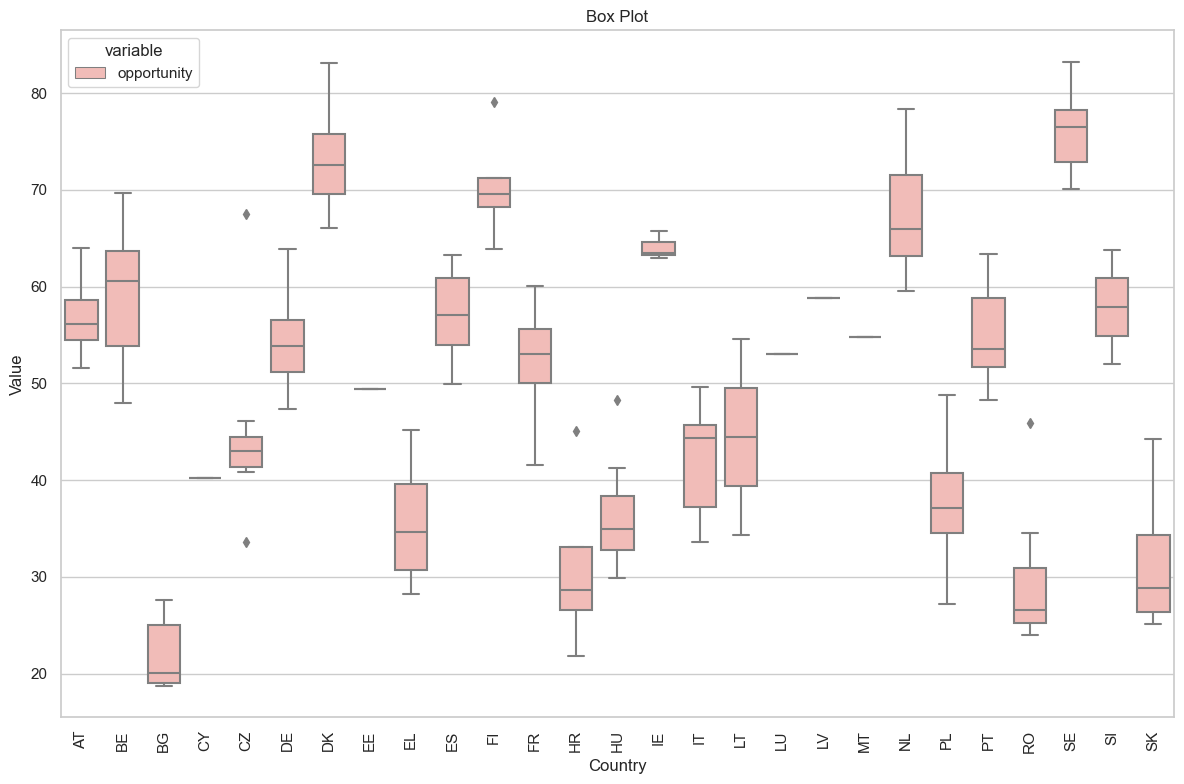

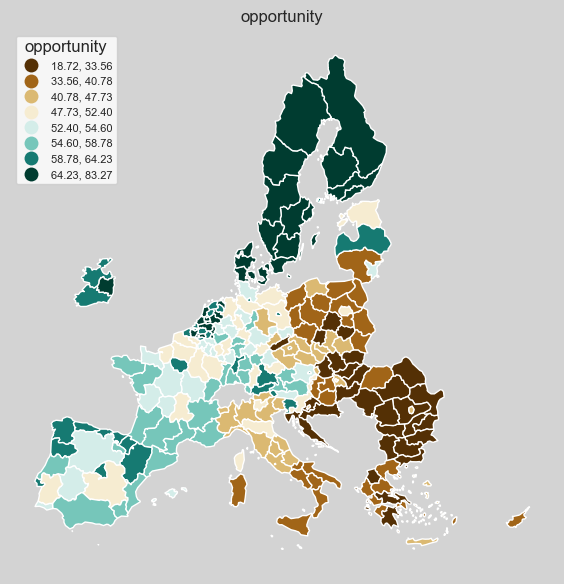

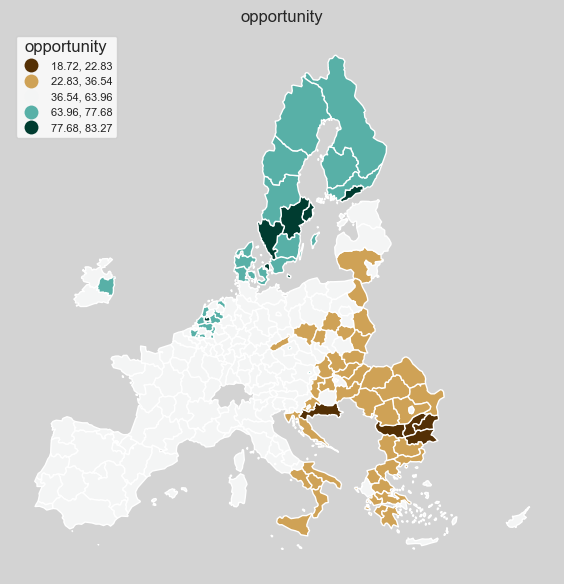

In [24]:
print('Figura 03.7')

# Agregación
beta = 0.5

X['opportunity'] = X.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Añadir a dimensiones

subset = X['opportunity']

dimensiones_df = pd.merge(dimensiones_df, subset, on='nuts_code')
dimensiones_gdf = pd.merge(dimensiones_gdf, subset, on='nuts_code')

# Graficos y mapas
variables = ['opportunity']
plot_bar_chart(dimensiones_df, variables, palette="Pastel2")
plot_box_chart(dimensiones_df, variables, palette="Pastel1")
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='quantiles')
plot_maps(dimensiones_gdf, variables, exclude_regions=overseas, scheme='stdmean')

* **Analisis de sensibilidad**

**[Figura 03.8]** Analisis para distintos betas

Figura 03.8


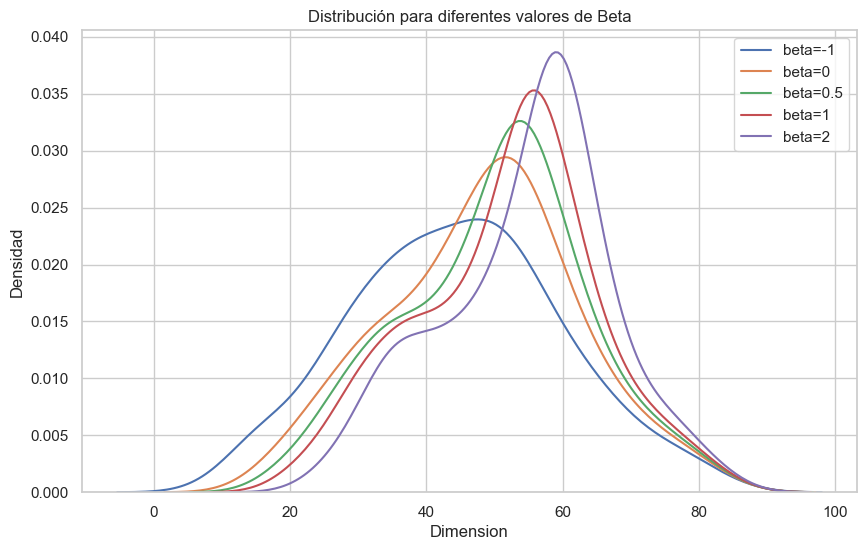

In [25]:
print('Figura 03.8')

data = {
    'nuts_code': df['nuts_code'],
}


for var in opportunity:
    data[var] = df[var]


X_test = pd.DataFrame(data)

X_test.set_index('nuts_code', inplace=True)

# Valores de beta a probar
beta_values = [-1, 0, 0.5, 1, 2]

# Almacenar los resultados
sensitivity_results = pd.DataFrame(index=X_test.index)

for beta in beta_values:
    sensitivity_results[f'opportunity{beta}'] = X_test.apply(lambda row: generalized_mean(row.values, beta), axis=1)

# Graficar los resultados de sensibilidad para diferentes valores de beta =====================================================

plt.figure(figsize=(10, 6))
for beta in beta_values:
    sns.kdeplot(sensitivity_results[f'opportunity{beta}'], label=f'beta={beta}', fill=False)

plt.title('Distribución para diferentes valores de Beta')
plt.xlabel('Dimension')
plt.ylabel('Densidad')
plt.legend()
    
plt.show()

**[Figura 03.9]**

Figura 03.9

Bootstrap:
+---+--------------------+--------------------------+---------------------------+---------------------------+
|   |      Variance      | Confidence Interval Mean | Confidence Interval Lower | Confidence Interval Upper |
+---+--------------------+--------------------------+---------------------------+---------------------------+
| 0 | 182.28819271043304 |    50.202971884704326    |     50.14917865027165     |      50.256765119137      |
+---+--------------------+--------------------------+---------------------------+---------------------------+

Datos originales:
Varianzas:
182.3318505325379

Intervalo de Confianza al 95%:
(50.17589410762928, 48.47459897991211, 51.87718923534646)



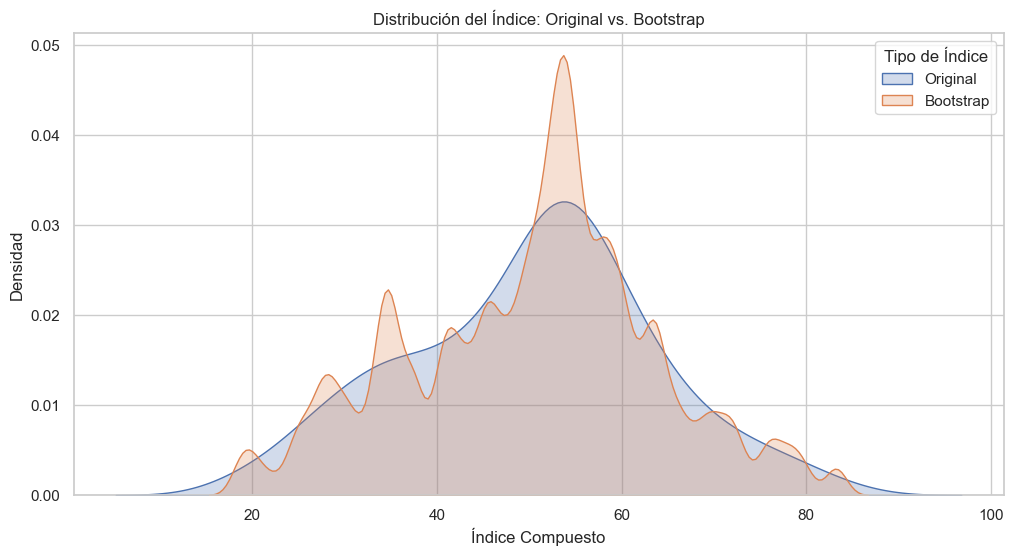

In [26]:
print('Figura 03.9')
print()

n_bootstrap=1000
beta = 0.5

# Realizar análisis bootstrap
bootstrap_df, results = bootstrap_analysis(X, beta, n_bootstrap=n_bootstrap)

print("Bootstrap:")
print(tabulate(results, headers='keys', tablefmt='pretty'))

print()

print('Datos originales:')
# Datos originales

varianza = subset.var()

intervalo_confianza = calcular_intervalo_confianza(subset)

print("Varianzas:")
print(varianza)
print("\nIntervalo de Confianza al 95%:")
print(intervalo_confianza)

print()

# Distribución

X['Indice']='Original'
bootstrap_df['Indice']='Bootstrap'

X_combined = X[['opportunity', 'Indice']].copy()
bootstrap_combined = bootstrap_df[['Bootstrap Index', 'Indice']].copy()

# Combinar ambos DataFrames
combined_df = pd.concat([X_combined, bootstrap_combined], axis=0)

# Crear la gráfica
plt.figure(figsize=(12, 6))

# Gráfico de densidad para los índices originales y bootstrap
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Original'], x='opportunity', label='Original', fill=True, common_norm=False)
sns.kdeplot(data=combined_df[combined_df['Indice'] == 'Bootstrap'], x='Bootstrap Index', label='Bootstrap', fill=True, common_norm=False)

# Configurar título y etiquetas
plt.title('Distribución del Índice: Original vs. Bootstrap')
plt.xlabel('Índice Compuesto')
plt.ylabel('Densidad')

# Mostrar leyenda
plt.legend(title='Tipo de Índice')

# Mostrar la gráfica
plt.show()

## Analisis Dimensiones

**[Figura 03.10]**

In [27]:
print('Figura 03.10')
dimensiones_df.describe()

Figura 03.10


basic_needs  foundations_wellbeing  opportunity
count   242.000000             242.000000   242.000000
mean     68.592973              65.750085    50.175894
std      13.721110              14.929747    13.503031
min       9.982744              21.189226    18.719860
25%      61.765380              56.941928    41.187763
50%      71.852399              70.328848    52.057655
75%      78.346437              74.363466    58.335474
max      91.397907              92.378837    83.273843

In [28]:
num_cols = dimensiones_df.select_dtypes(include=['float64', 'int64'])
dimensiones_df[num_cols.columns] = num_cols.round(2)

In [29]:
variables = [
    'basic_needs',
    'foundations_wellbeing',
    'opportunity'
]

**[Figura 03.11]**

Figura 03.11


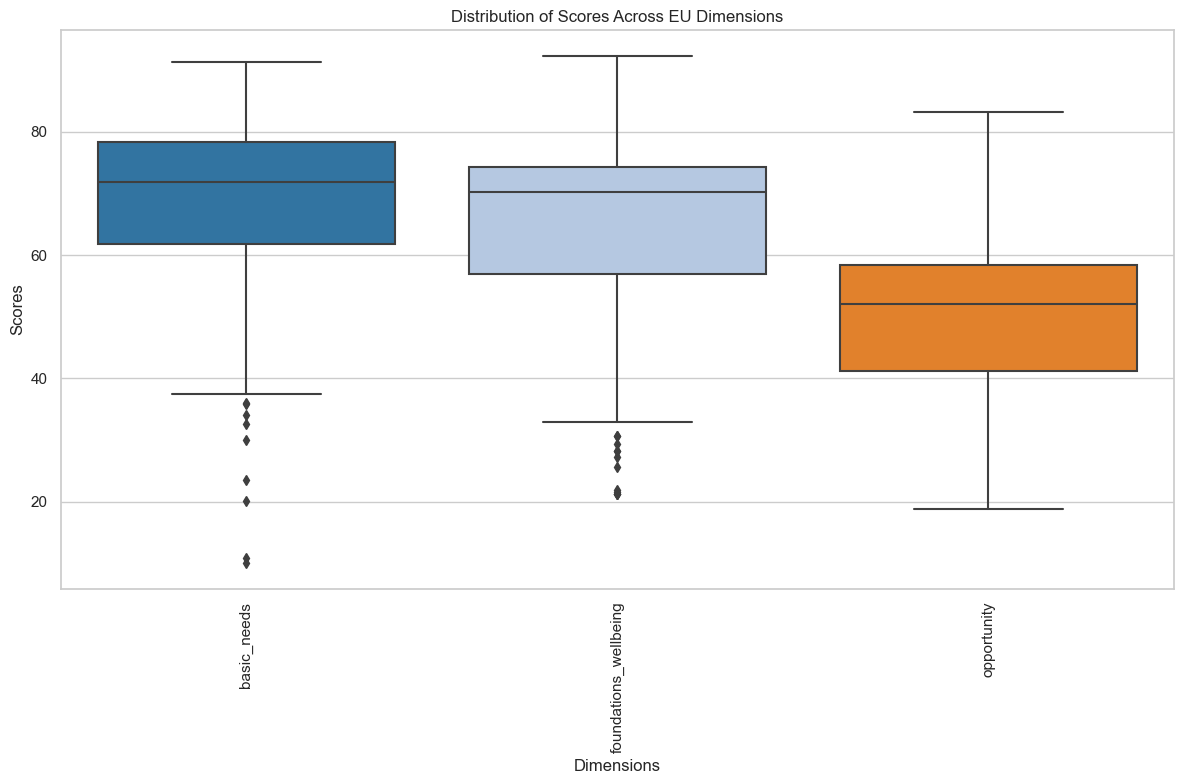

In [30]:
print('Figura 03.11')

# Boxplot

df_boxplot = dimensiones_df[variables]

plt.figure(figsize=(12, 8))

ax = sns.boxplot(data=df_boxplot, palette='tab20')

plt.xlabel('Dimensions')
plt.ylabel('Scores')
plt.title('Distribution of Scores Across EU Dimensions')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

**[Figura 03.12]**

Figura 03.12


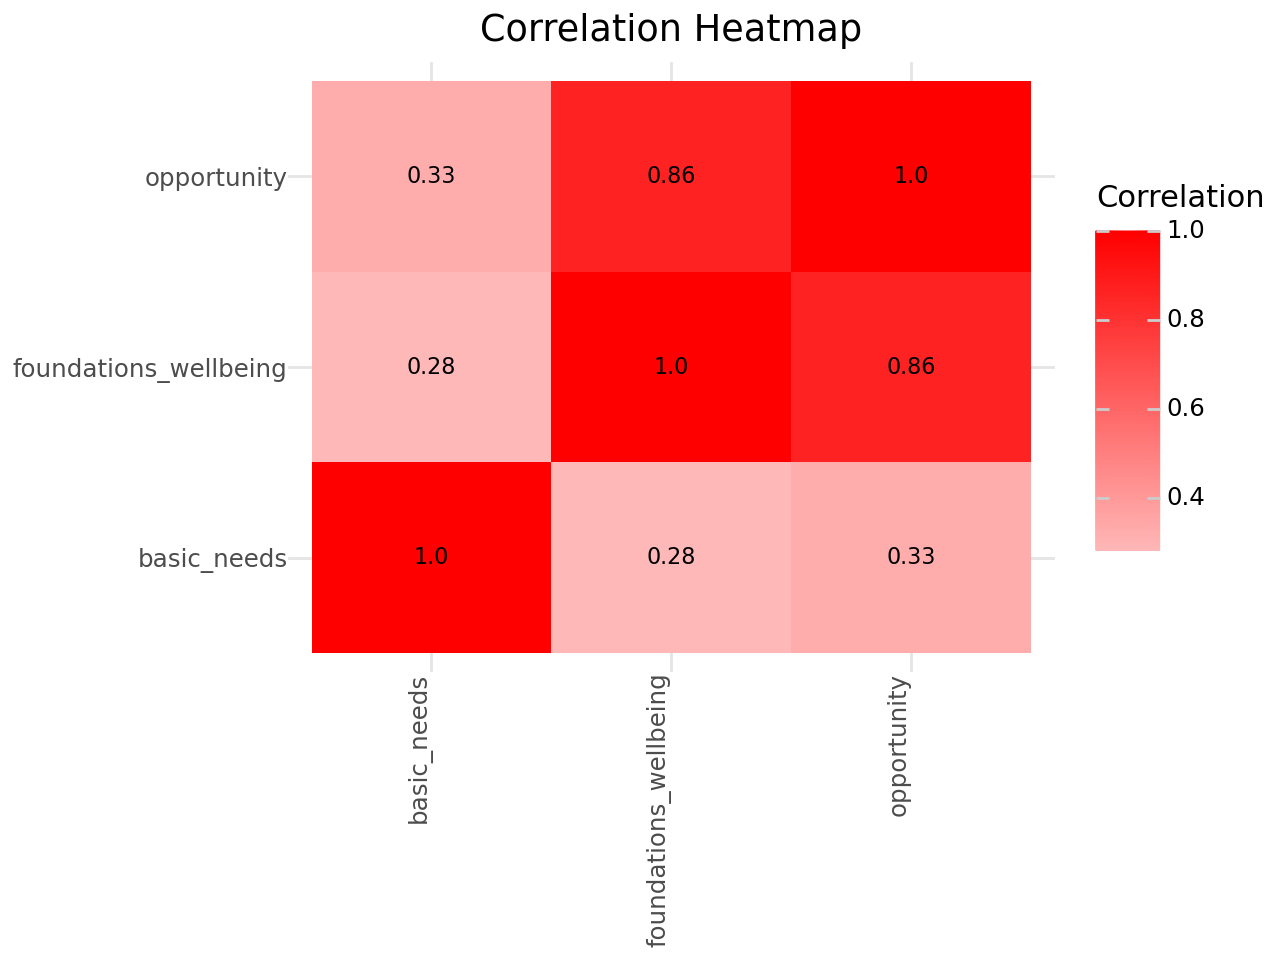

In [31]:
print('Figura 03.12')
corr = dimensiones_df.select_dtypes(include='number').corr()
corr_melt = corr.reset_index().melt(id_vars='index')
corr_melt.columns = ['Var1', 'Var2', 'Correlation']

p = (ggplot(corr_melt, aes(x='Var1', y='Var2', fill='Correlation')) +
     geom_tile() +
     geom_text(aes(label=corr_melt['Correlation'].round(2)), size=8, color='black') +
     scale_fill_gradient2(low='blue', mid='white', high='red', midpoint=0) +
     theme_minimal() +
     theme(axis_text_x=element_text(rotation=90, hjust=1)) +
     labs(x='', y='', title='Correlation Heatmap'))

print(p)

**[Figura 03.13]**

Figura 03.13


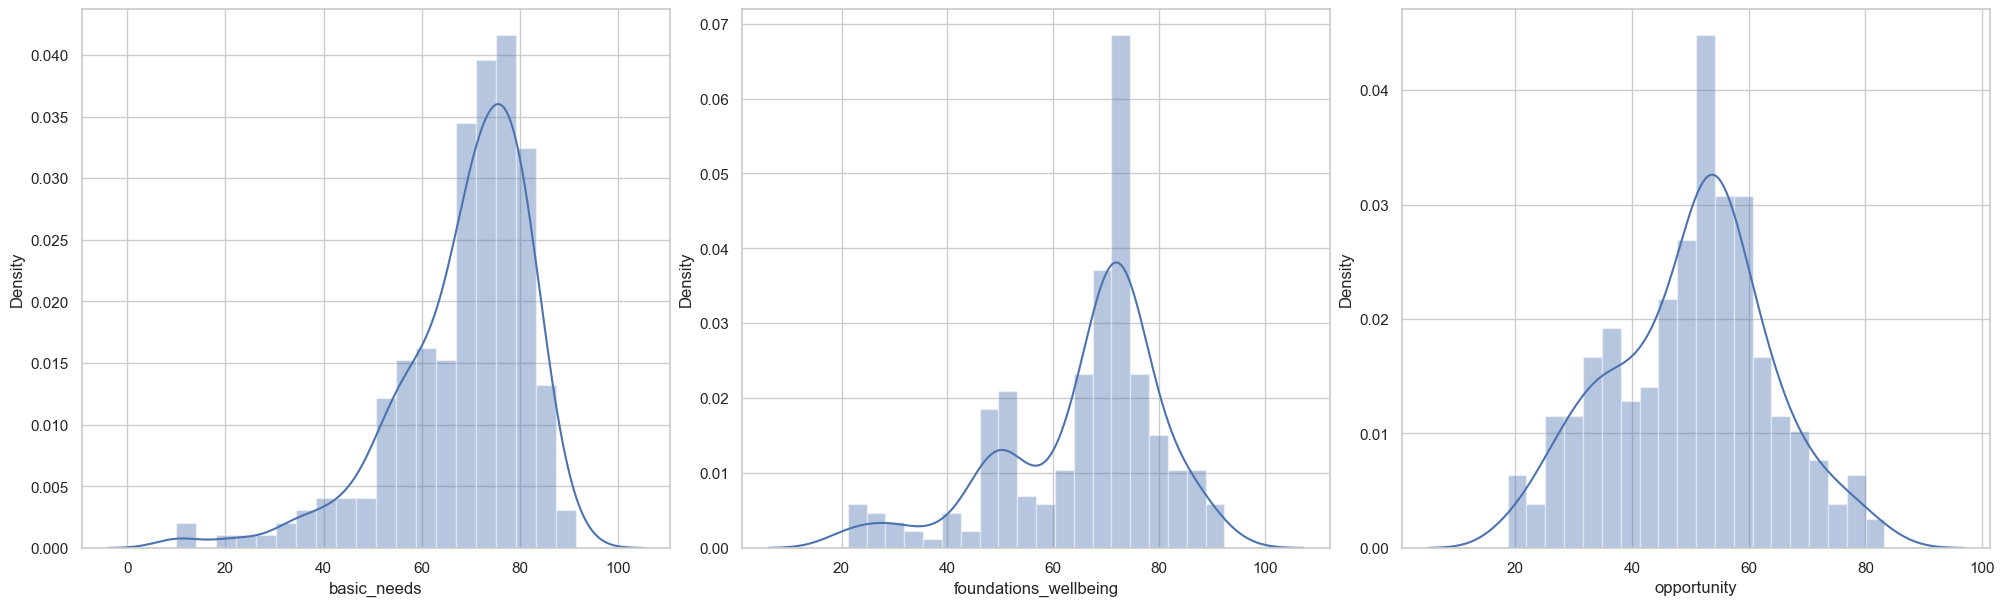

In [32]:
print('Figura 03.13')
num_cols = dimensiones_df.select_dtypes(include=['number']).columns

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
axs = axs.flatten()

index = 0
for col in dimensiones_df[num_cols]:
    sns.distplot(dimensiones_df[col], bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

**[Figura 03.13]**

Figura 03.13


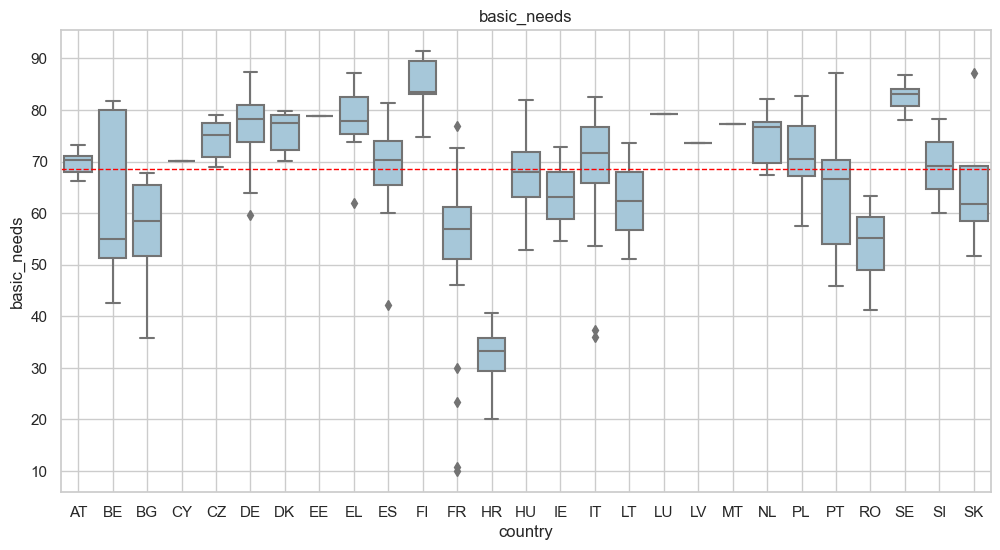

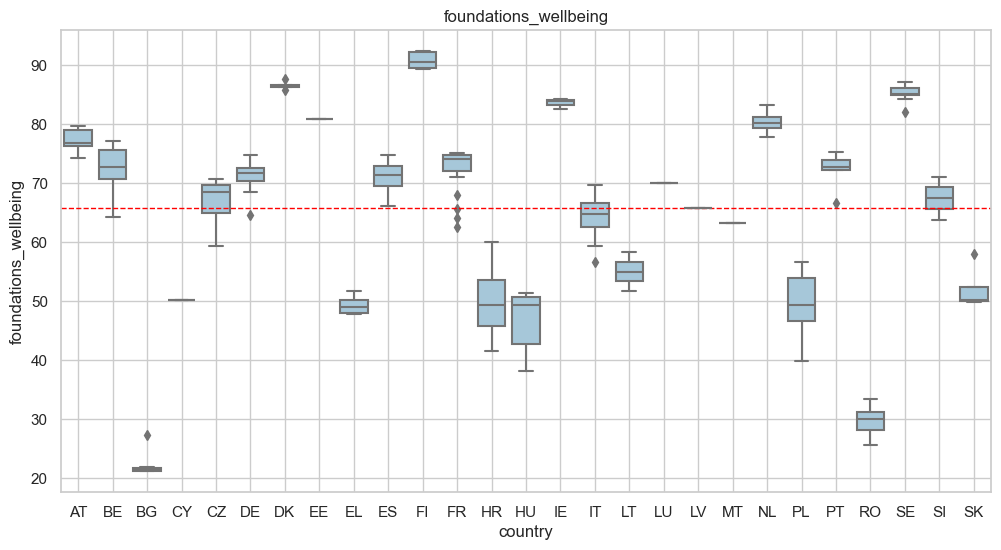

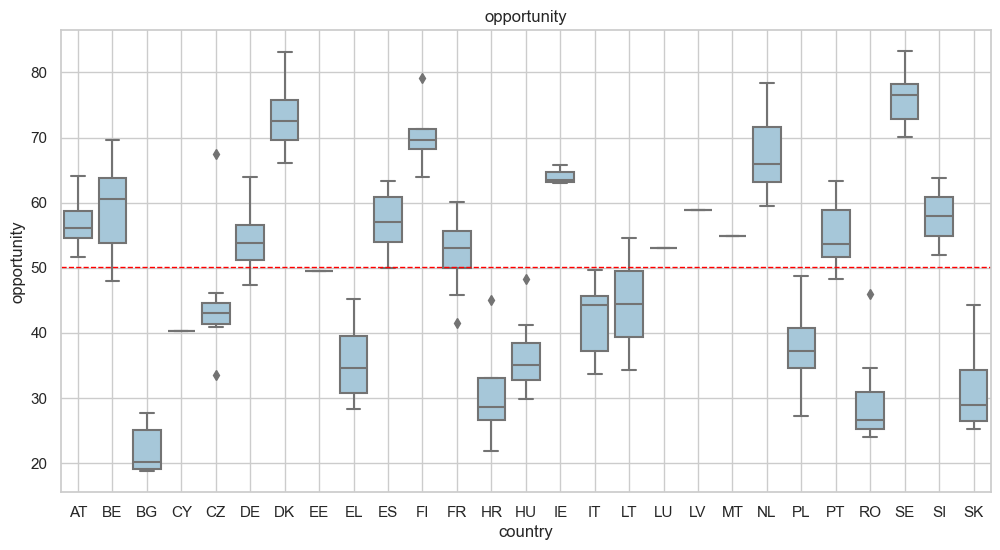

In [33]:
print('Figura 03.13')

num_cols= dimensiones_df.select_dtypes(include=['float64', 'int64'])

country_col = 'country'

for col in num_cols:
    plt.figure(figsize=(12, 6))

    sns.boxplot(x='country', y=col, data=dimensiones_df, color='#9ecae1')

    mean = dimensiones_df[col].mean()
    plt.axhline(mean, color='red', linestyle='--', linewidth=1, label=f'Media ({mean:.2f})')

    plt.title(col)

    plt.grid(True)

    plt.show()

**[Figura 03.14]**

Figura 03.14


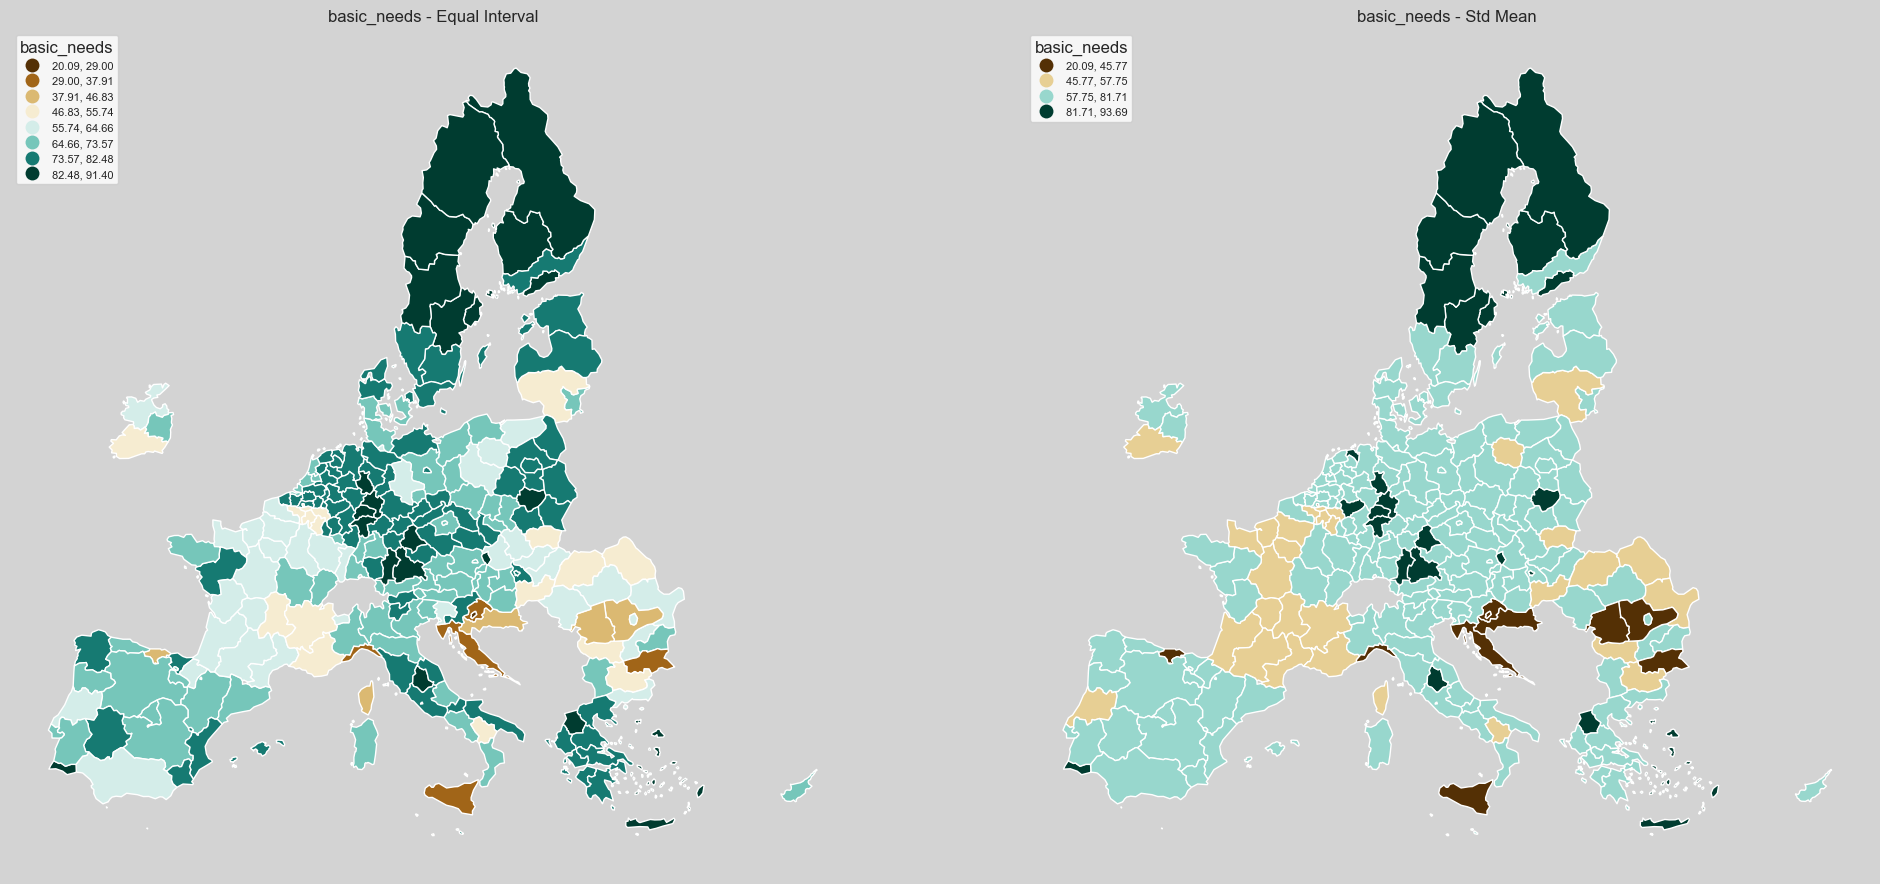

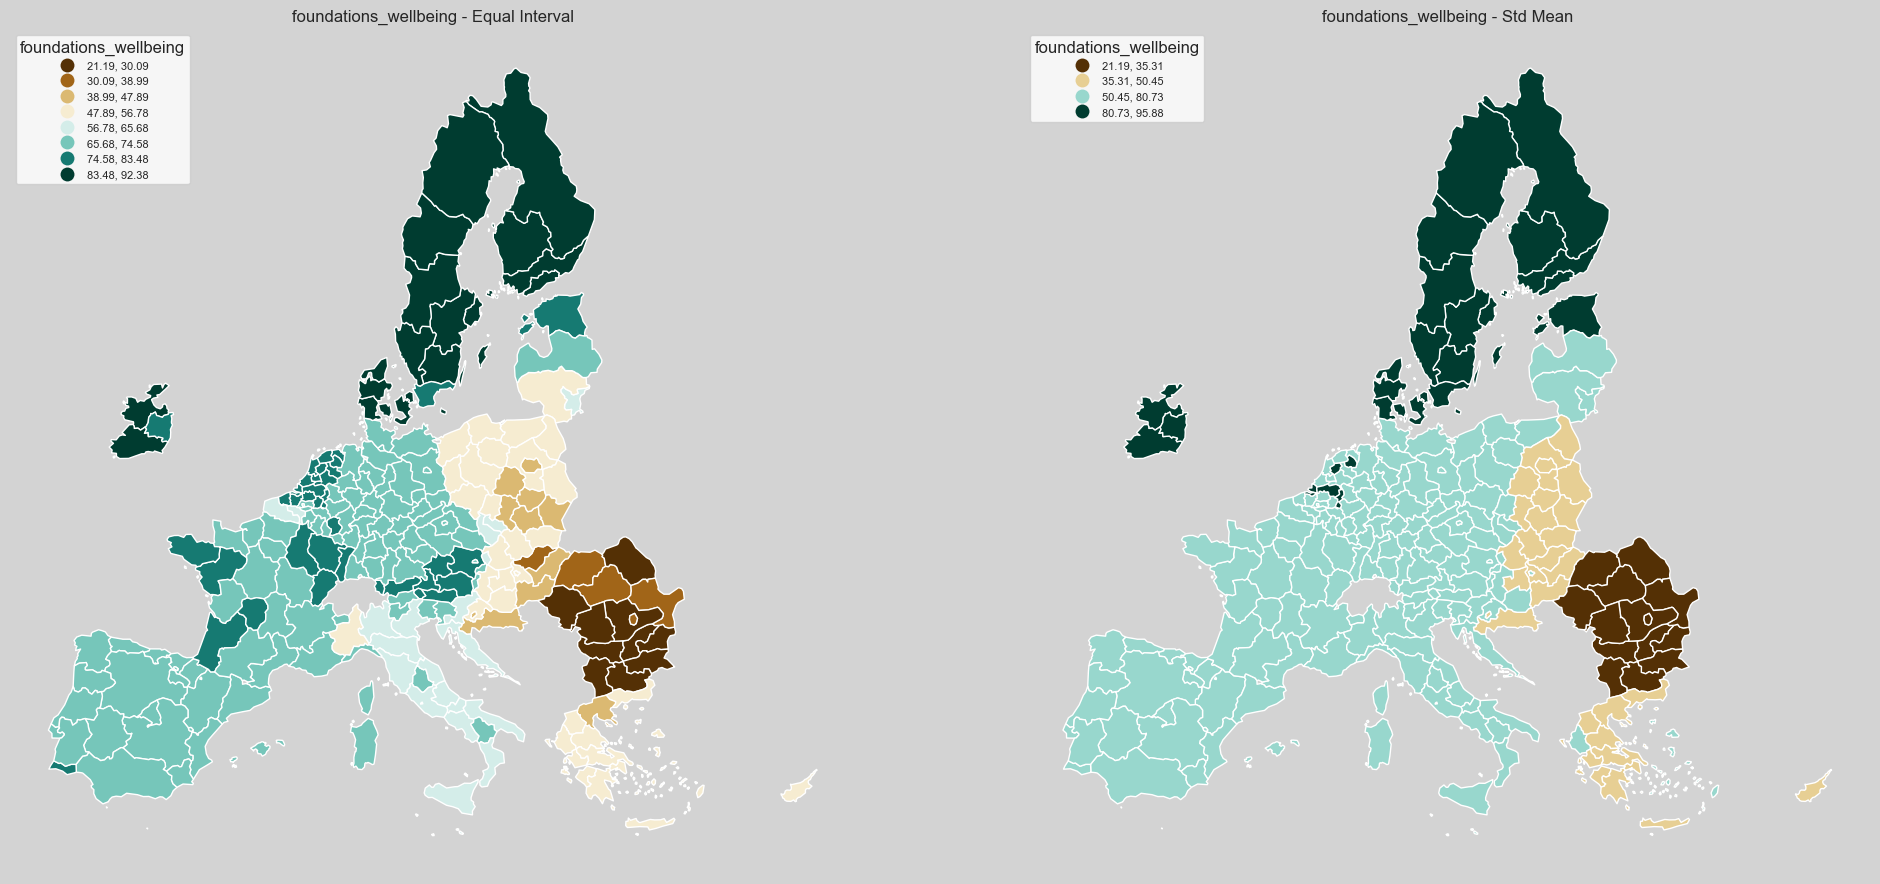

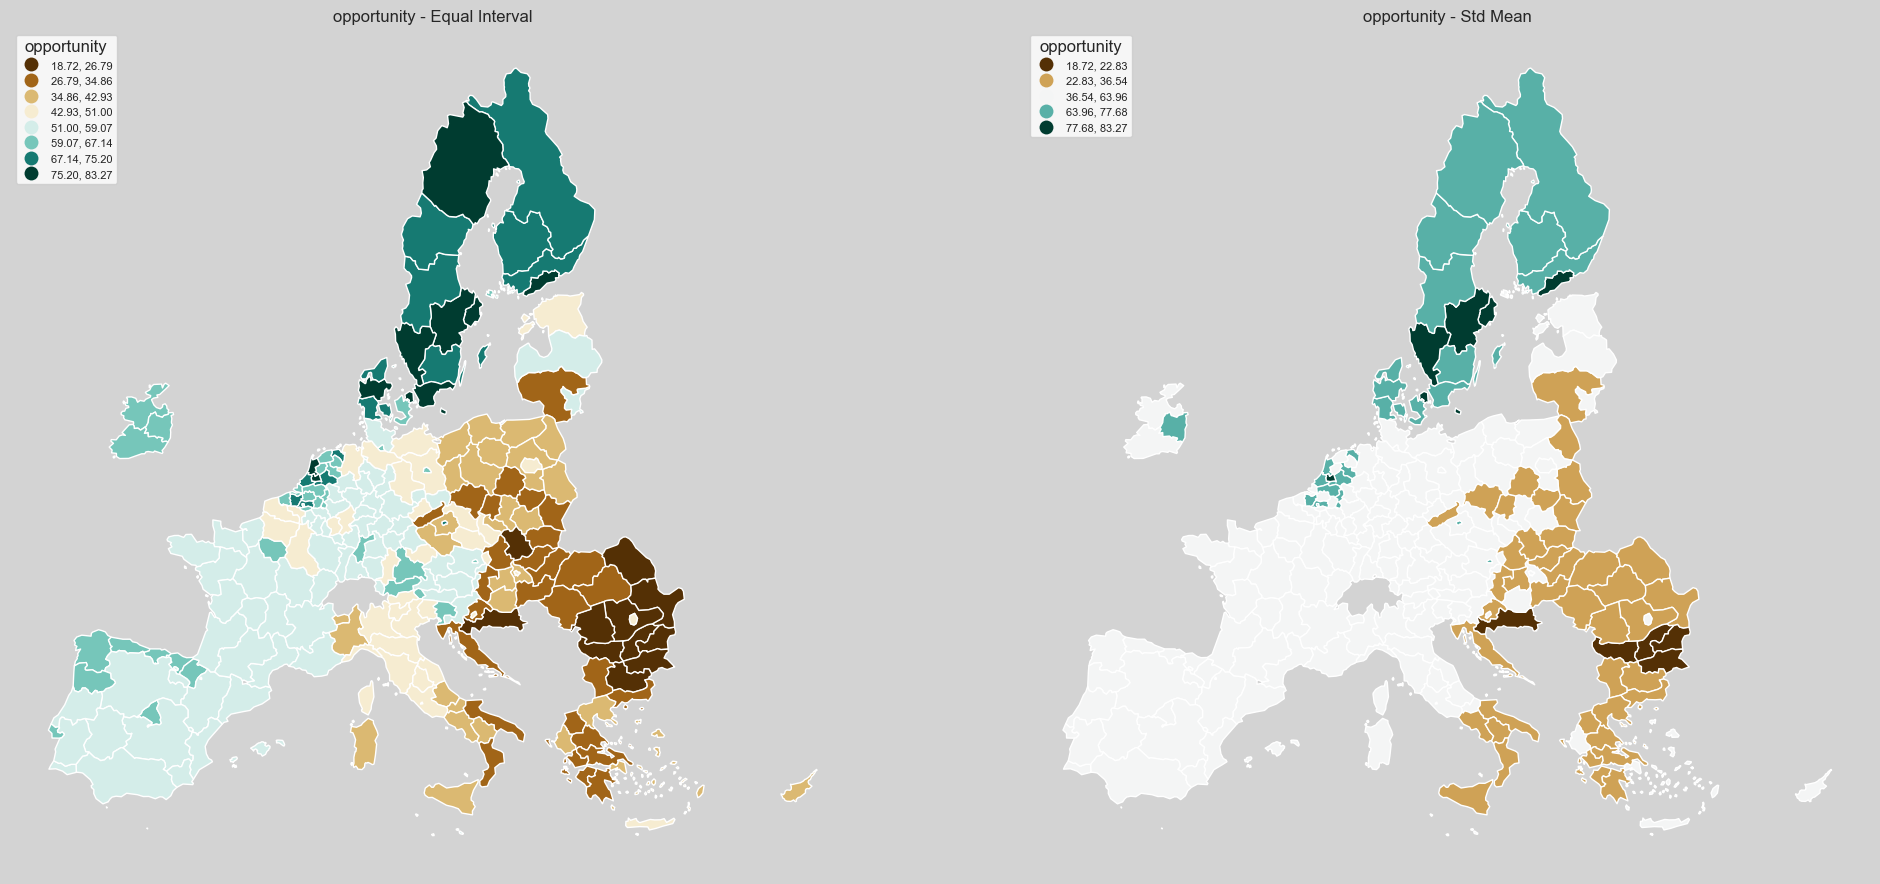

In [34]:
print('Figura 03.14')
# Mapas

filtered = dimensiones_gdf[~dimensiones_gdf['region'].isin(overseas)]

num_cols = filtered.select_dtypes(include=np.number).columns


for column in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Crear dos subgráficos pareados

    fig.patch.set_facecolor('lightgrey')

    # Primer gráfico usando scheme='equal_interval'
    filtered.plot(column=column,
                  scheme='equal_interval',
                  k=8,
                  cmap='BrBG',
                  edgecolor='w',
                  legend=True,
                  ax=axes[0],
                  legend_kwds={'loc': 'upper left', 'fontsize':'8', 'title': column}
    )
    axes[0].set_title(f'{column} - Equal Interval')
    axes[0].set_axis_off()

    # Segundo gráfico usando scheme='std_mean'
    filtered.plot(column=column,
                  scheme='std_mean',
                  cmap='BrBG',
                  edgecolor='w',
                  legend=True,
                  ax=axes[1],
                  legend_kwds={'loc': 'upper left', 'fontsize':'8', 'title': column}
    )
    axes[1].set_title(f'{column} - Std Mean')
    axes[1].set_axis_off()

    plt.show()

**[Figura 03.15]**

Figura 03.15


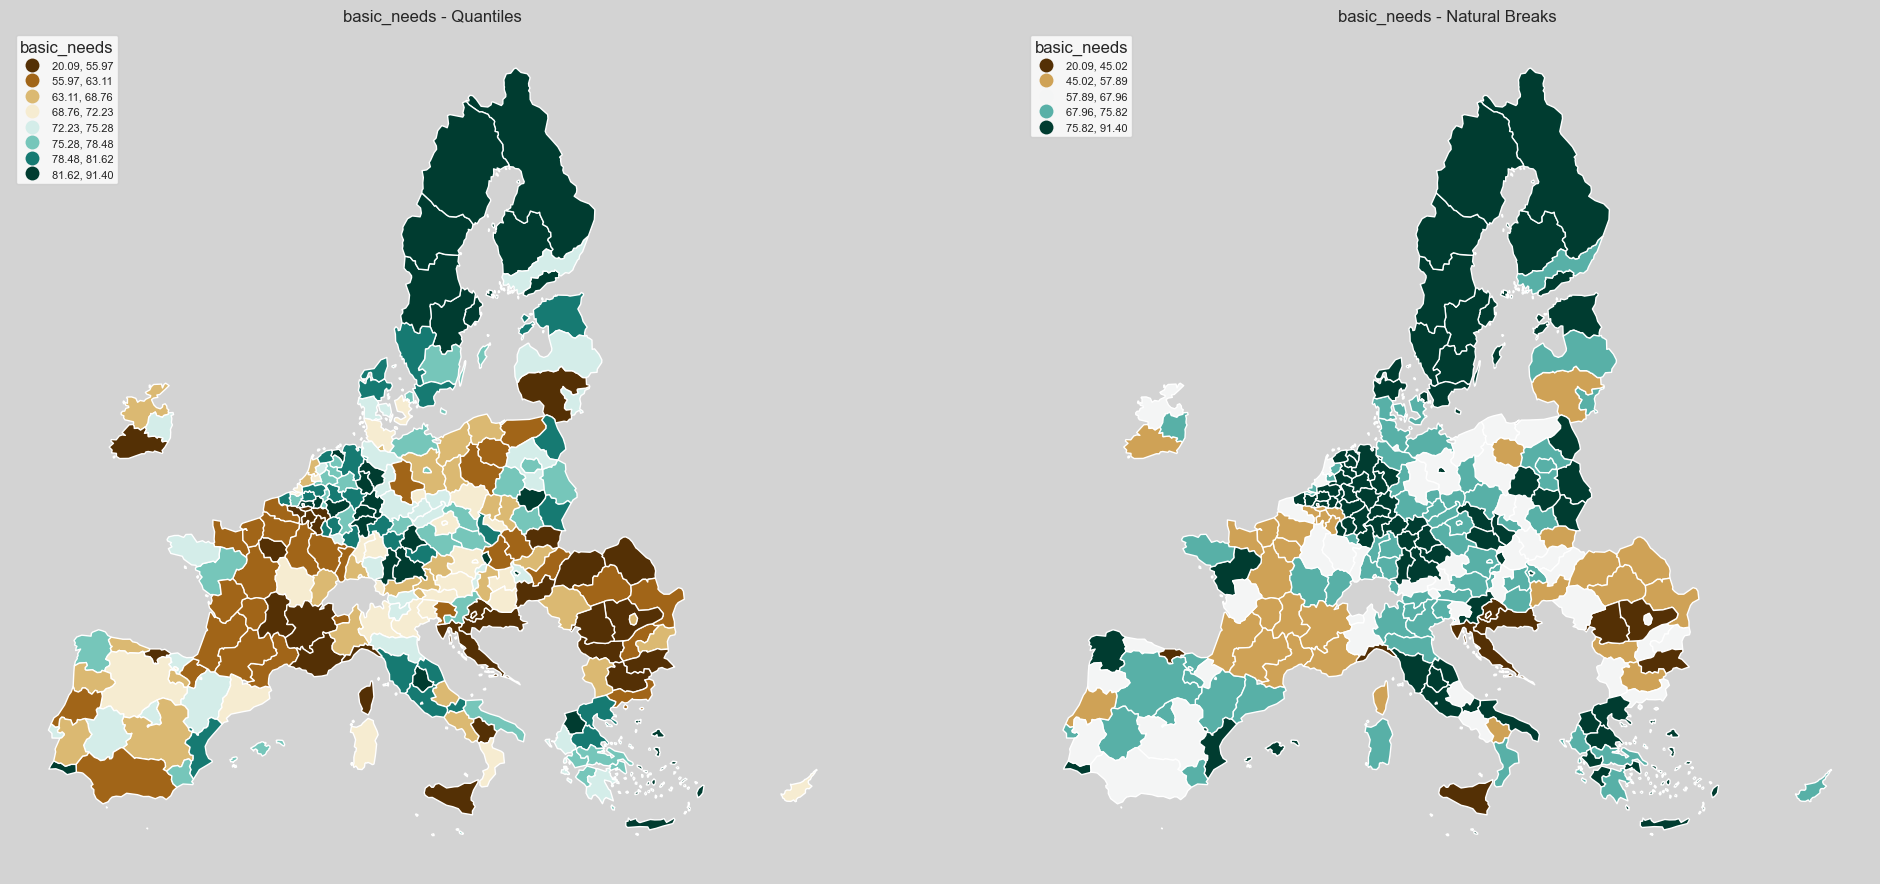

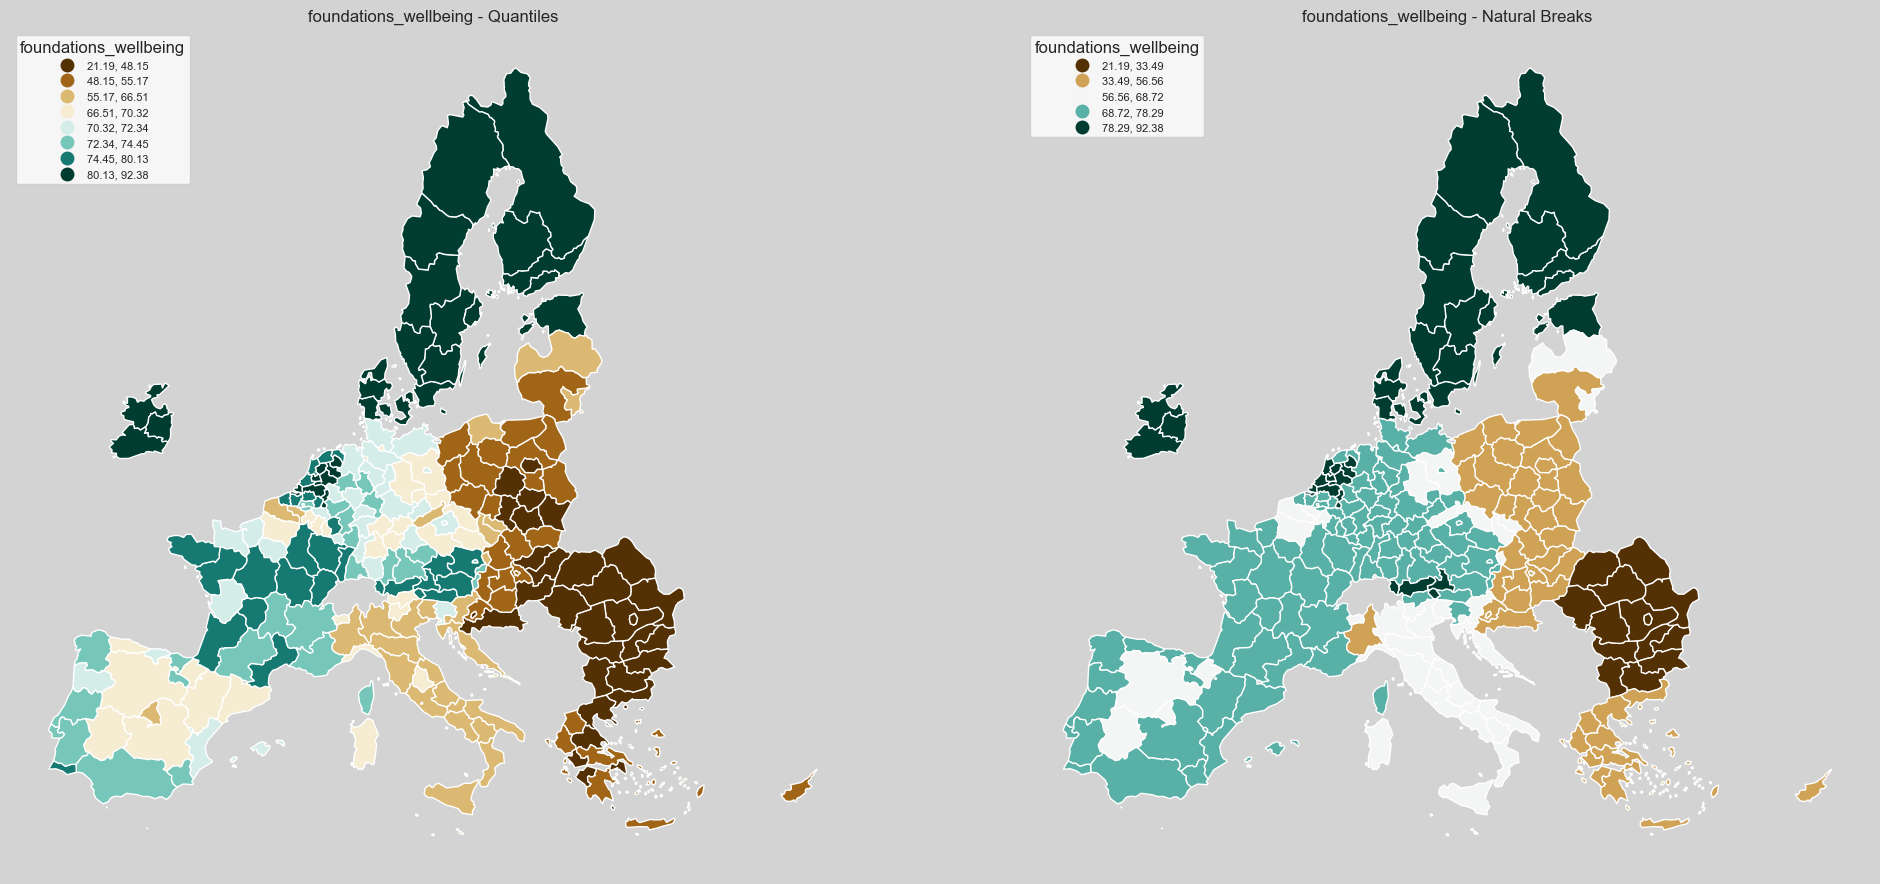

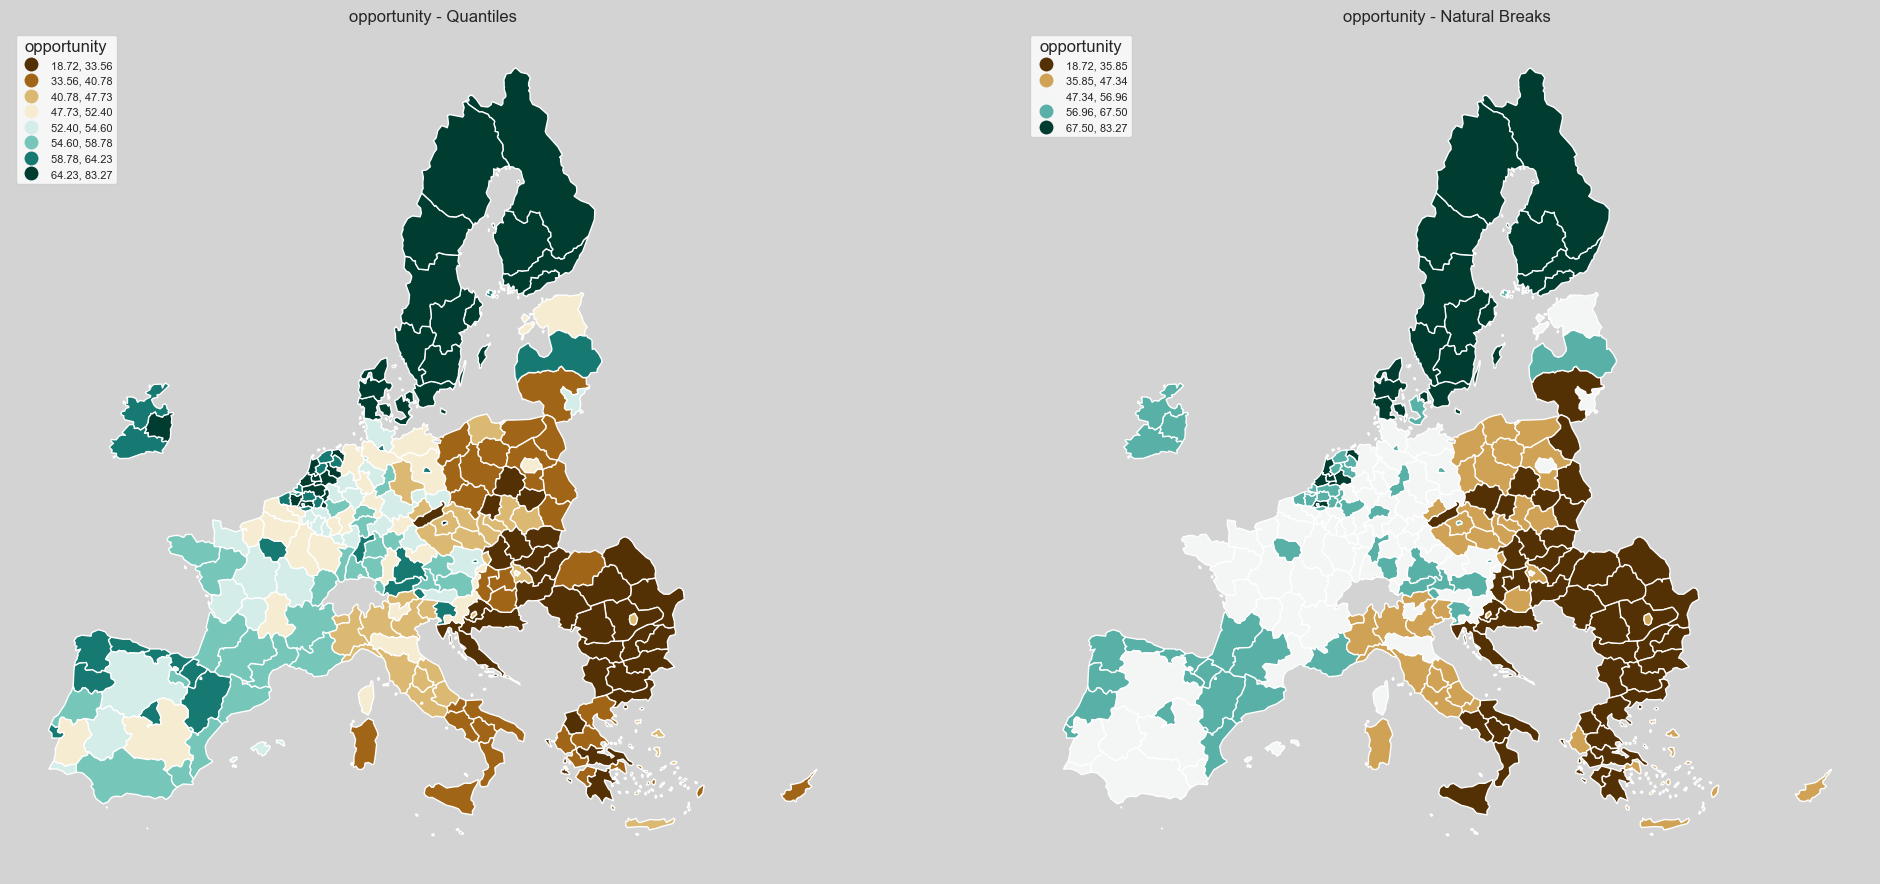

In [35]:
print('Figura 03.15')
# Mapas

filtered = dimensiones_gdf[~dimensiones_gdf['region'].isin(overseas)]

num_cols = filtered.select_dtypes(include=np.number).columns


for column in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(24, 12))  # Crear dos subgráficos pareados

    fig.patch.set_facecolor('lightgrey')

    # Primer gráfico usando scheme='quantiles'
    filtered.plot(column=column,
                  scheme='quantiles',
                  k=8,
                  cmap='BrBG',
                  edgecolor='w',
                  legend=True,
                  ax=axes[0],
                  legend_kwds={'loc': 'upper left', 'fontsize':'8', 'title': column}
    )
    axes[0].set_title(f'{column} - Quantiles')
    axes[0].set_axis_off()

    # Segundo gráfico usando scheme='std_mean'
    filtered.plot(column=column,
                  scheme='natural_breaks',
                  cmap='BrBG',
                  edgecolor='w',
                  legend=True,
                  ax=axes[1],
                  legend_kwds={'loc': 'upper left', 'fontsize':'8', 'title': column}
    )
    axes[1].set_title(f'{column} - Natural Breaks')
    axes[1].set_axis_off()

    plt.show()

## **GDP**

In [36]:
dimensiones_df=pd.merge(dimensiones_df, df[['nuts_code','gdp_per_capita_2022']], how='left', on='nuts_code')


**[Figura 03.16]**

In [37]:
print('Figura 03.16')
dimensiones_df.describe()

Figura 03.16


basic_needs  foundations_wellbeing  opportunity  gdp_per_capita_2022
count   242.000000             242.000000   242.000000           242.000000
mean     68.592934              65.749835    50.175950            22.616020
std      13.720825              14.929801    13.503089            15.959313
min       9.980000              21.190000    18.720000             0.000000
25%      61.767500              56.940000    41.190000            10.621646
50%      71.850000              70.325000    52.060000            21.645796
75%      78.345000              74.367500    58.337500            31.864937
max      91.400000              92.380000    83.270000           100.000000

**[Figura 03.17]**

Figura 03.17


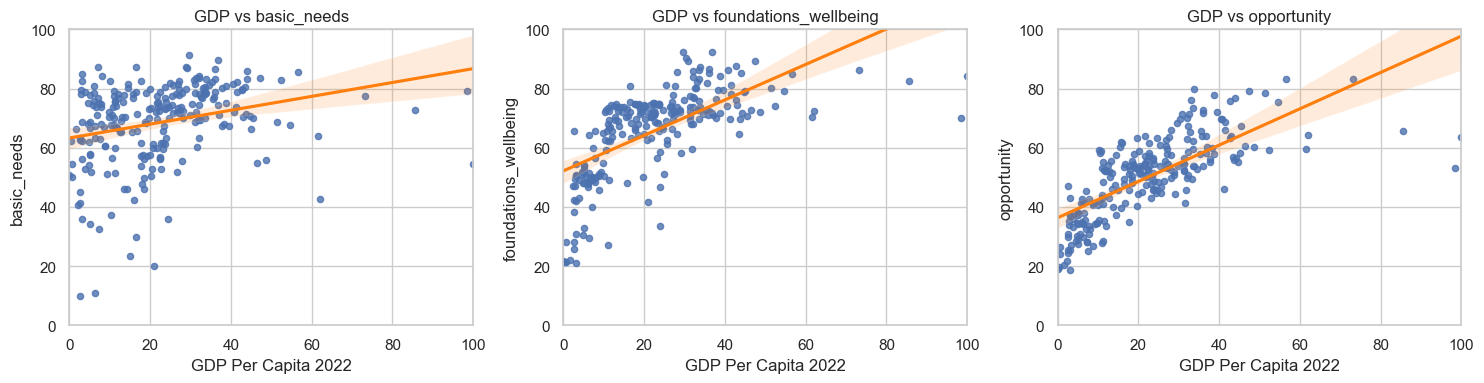

In [38]:
print('Figura 03.17')
# Número de filas y columnas en el grid
n_vars = len(variables)
n_cols = 3  # Puedes ajustar esto según el número de variables
n_rows = (n_vars + n_cols - 1) // n_cols  # Calcula el número de filas necesarias

# Crear el grid de gráficos de dispersión con línea de regresión
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for ax, var in zip(axes, variables):
    sns.regplot(x='gdp_per_capita_2022', y=var, data=dimensiones_df, ax=ax, scatter_kws={'s':20}, line_kws={'color':'#ff7f0e'})
    ax.set_title(f'GDP vs {var}')
    ax.set_xlabel('GDP Per Capita 2022')
    ax.set_ylabel(var)
    ax.set_xlim(0, 100)  # Limitar el eje x a [0, 100]
    ax.set_ylim(0, 100)  # Limitar el eje y a [0, 100]

# Eliminar ejes vacíos si hay menos gráficos que subgrillas
for ax in axes[len(variables):]:
    ax.remove()

plt.tight_layout()
plt.show()



**[Figura 3.18]**

In [39]:
from scipy.stats import pearsonr
print('Figura 3.18')
print()
# Inicializar listas para los resultados
results = {
    'Variable': [],
    'Correlación': [],
    'p-Valor': [],
    'Significancia': []
}

# Calcular correlaciones y p-valores
for var in variables:
    try:
        corr, p_value = pearsonr(dimensiones_df['gdp_per_capita_2022'], dimensiones_df[var])

        # Determinar significancia
        if p_value < 0.05:
            significancia = 'Significativo'
        else:
            significancia = 'No Significativo'

        # Evaluar dirección de la correlación
        if corr > 0:
            direccion = 'Positiva'
        elif corr < 0:
            direccion = 'Negativa'
        else:
            direccion = 'Nula'

        # Agregar resultados a las listas
        results['Variable'].append(var)
        results['Correlación'].append(corr)
        results['p-Valor'].append(p_value)
        results['Significancia'].append(f'{significancia}, {direccion}')
    except KeyError as e:
        print(f"Error con la variable {var}: {e}")

# Crear un DataFrame de pandas
results_df = pd.DataFrame(results)

# Mostrar la tabla usando tabulate para una presentación más estilizada
print('GDP Per Capita 2022')
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', floatfmt=(".3f", ".3f", ".3f")))




Figura 3.18

GDP Per Capita 2022
╒════╤═══════════════════════╤═══════════════╤═════════════╤═════════════════════════╕
│    │ Variable              │   Correlación │     p-Valor │ Significancia           │
╞════╪═══════════════════════╪═══════════════╪═════════════╪═════════════════════════╡
│  0 │ basic_needs           │         0.273 │ 1.68483e-05 │ Significativo, Positiva │
├────┼───────────────────────┼───────────────┼─────────────┼─────────────────────────┤
│  1 │ foundations_wellbeing │         0.641 │ 2.15237e-29 │ Significativo, Positiva │
├────┼───────────────────────┼───────────────┼─────────────┼─────────────────────────┤
│  2 │ opportunity           │         0.726 │ 6.90448e-41 │ Significativo, Positiva │
╘════╧═══════════════════════╧═══════════════╧═════════════╧═════════════════════════╛


## Guardar dataset Dimensiones

In [40]:
dimensiones_df.to_csv('03_dimensiones_minmax.csv',
                     index = False)